In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

W0730 02:54:34.434454 140065419872128 deprecation.py:323] From <ipython-input-2-21947dd83f09>:8: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0730 02:54:34.436264 140065419872128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0730 02:54:34.443022 140065419872128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0730 02:54:34.872762 140065419872128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0730 02:54:34.962907 140065419872128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


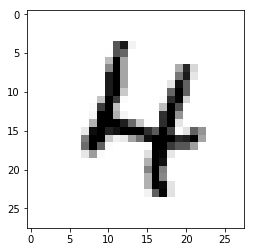

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [0]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [0]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [0]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

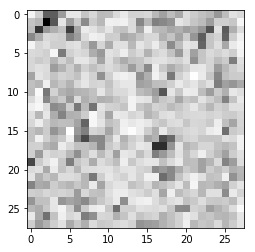

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [0]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

W0730 02:54:37.131973 140065419872128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

In [12]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


In [0]:

# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [0]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.6924244 dLossFake: 0.69497985
dLossReal: 0.047063436 dLossFake: 0.012052105
dLossReal: 0.00057150936 dLossFake: 0.0009904931
Iteration: 0 at 2019-07-30 02:56:28.544008


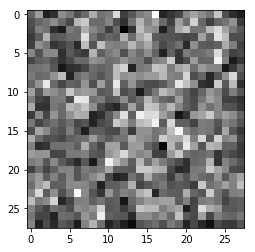

Estimate: [[-7.909439]]
Iteration: 100 at 2019-07-30 02:57:50.397594


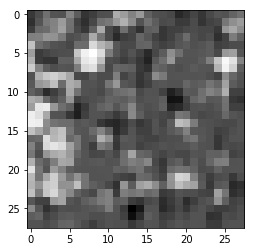

Estimate: [[-8.085486]]
Iteration: 200 at 2019-07-30 02:59:12.613200


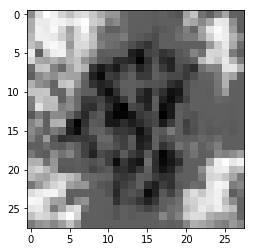

Estimate: [[-5.981943]]
Iteration: 300 at 2019-07-30 03:00:34.705354


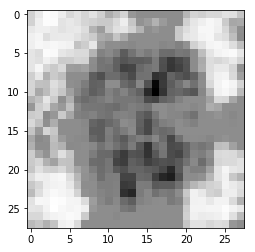

Estimate: [[-6.9606867]]
Iteration: 400 at 2019-07-30 03:01:57.228273


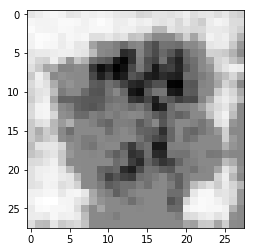

Estimate: [[-3.7479064]]
Iteration: 500 at 2019-07-30 03:03:19.227487


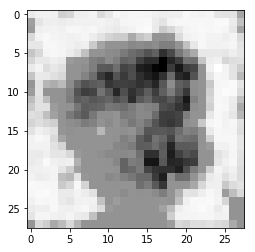

Estimate: [[-12.933536]]
Iteration: 600 at 2019-07-30 03:04:41.162175


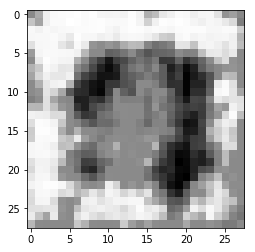

Estimate: [[-6.9375987]]
Iteration: 700 at 2019-07-30 03:06:03.288211


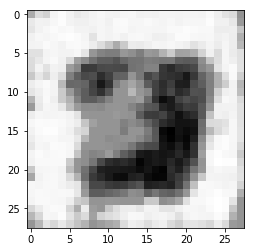

Estimate: [[-5.870799]]
Iteration: 800 at 2019-07-30 03:07:25.728711


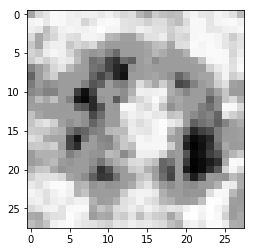

Estimate: [[3.2721972]]
Iteration: 900 at 2019-07-30 03:08:46.606991


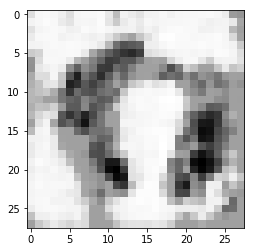

Estimate: [[-12.235671]]
Iteration: 1000 at 2019-07-30 03:10:07.701747


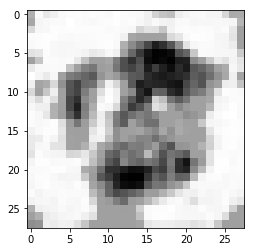

Estimate: [[-6.14018]]
Iteration: 1100 at 2019-07-30 03:11:29.393598


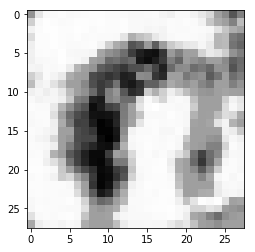

Estimate: [[-0.57483065]]
Iteration: 1200 at 2019-07-30 03:12:50.676755


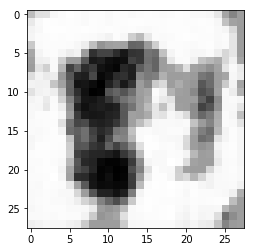

Estimate: [[-5.8968782]]
Iteration: 1300 at 2019-07-30 03:14:11.682936


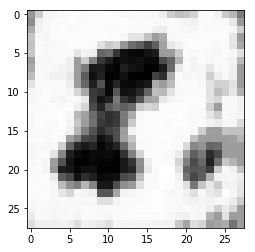

Estimate: [[-4.9781165]]
Iteration: 1400 at 2019-07-30 03:15:32.445170


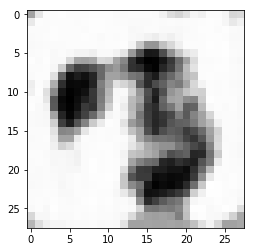

Estimate: [[-3.1329155]]
Iteration: 1500 at 2019-07-30 03:16:54.126986


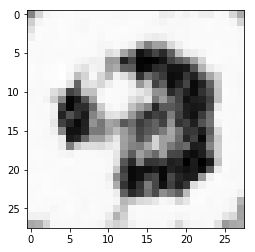

Estimate: [[-7.8291245]]
Iteration: 1600 at 2019-07-30 03:18:14.937633


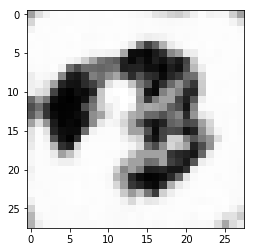

Estimate: [[-6.185478]]
Iteration: 1700 at 2019-07-30 03:19:36.472874


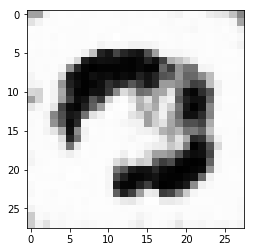

Estimate: [[-6.149245]]
Iteration: 1800 at 2019-07-30 03:20:57.721108


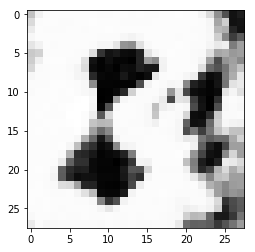

Estimate: [[-6.083828]]
Iteration: 1900 at 2019-07-30 03:22:19.216698


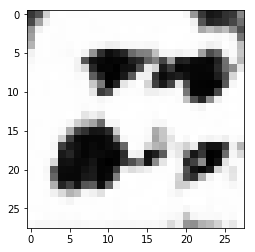

Estimate: [[-7.3576446]]
Iteration: 2000 at 2019-07-30 03:23:39.422425


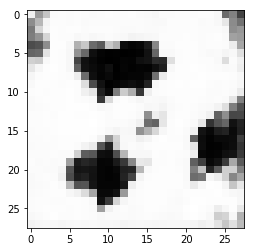

Estimate: [[-3.8380983]]
Iteration: 2100 at 2019-07-30 03:25:00.149037


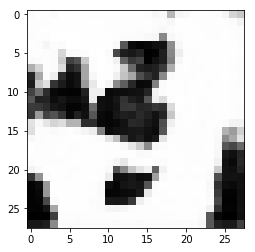

Estimate: [[-4.056945]]
Iteration: 2200 at 2019-07-30 03:26:20.530736


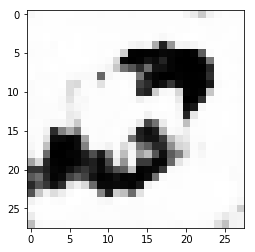

Estimate: [[-5.868496]]
Iteration: 2300 at 2019-07-30 03:27:41.297951


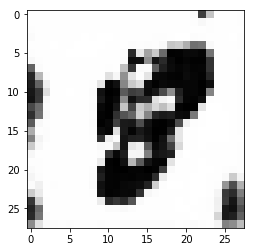

Estimate: [[-6.099792]]
Iteration: 2400 at 2019-07-30 03:29:01.883845


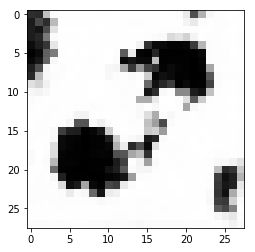

Estimate: [[-1.2646478]]
Iteration: 2500 at 2019-07-30 03:30:22.500047


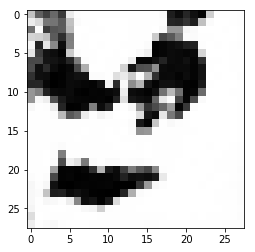

Estimate: [[-6.9741282]]
Iteration: 2600 at 2019-07-30 03:31:43.059564


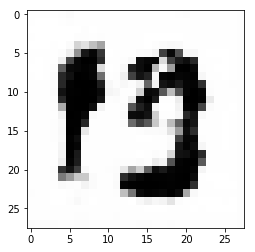

Estimate: [[-6.5381517]]
Iteration: 2700 at 2019-07-30 03:33:03.888602


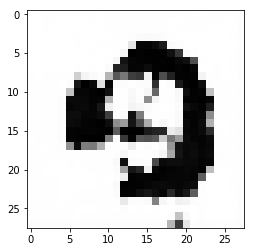

Estimate: [[-7.6304903]]
Iteration: 2800 at 2019-07-30 03:34:24.492807


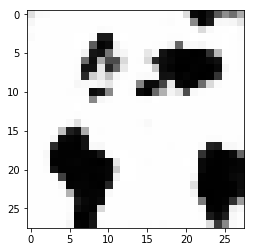

Estimate: [[-7.614813]]
Iteration: 2900 at 2019-07-30 03:35:45.022253


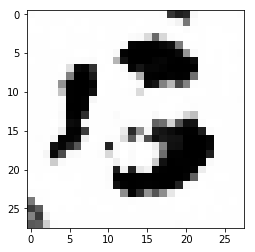

Estimate: [[-8.455991]]
Iteration: 3000 at 2019-07-30 03:37:05.848183


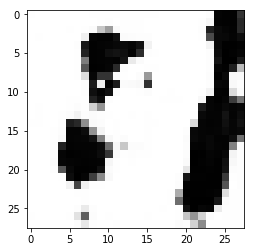

Estimate: [[-3.7383113]]
Iteration: 3100 at 2019-07-30 03:38:27.914385


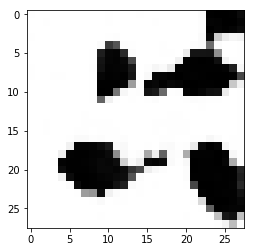

Estimate: [[-7.0688415]]
Iteration: 3200 at 2019-07-30 03:39:50.083701


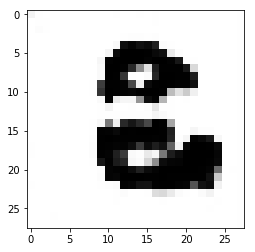

Estimate: [[-1.7884032]]
Iteration: 3300 at 2019-07-30 03:41:12.073417


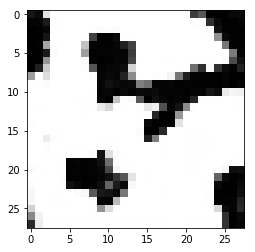

Estimate: [[-4.8951755]]
Iteration: 3400 at 2019-07-30 03:42:34.621107


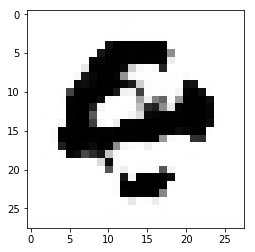

Estimate: [[1.3857785]]
Iteration: 3500 at 2019-07-30 03:43:56.514920


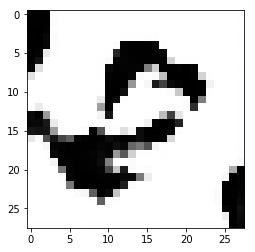

Estimate: [[2.4923763]]
Iteration: 3600 at 2019-07-30 03:45:18.660964


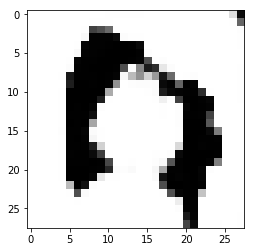

Estimate: [[-10.622705]]
Iteration: 3700 at 2019-07-30 03:46:40.588396


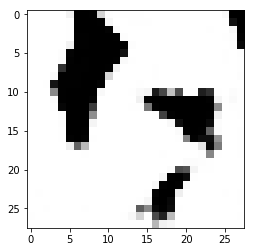

Estimate: [[-4.023415]]
Iteration: 3800 at 2019-07-30 03:48:03.134471


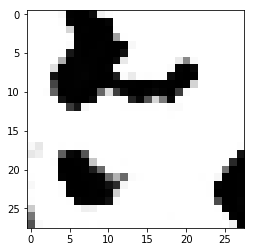

Estimate: [[-19.390814]]
Iteration: 3900 at 2019-07-30 03:49:25.171464


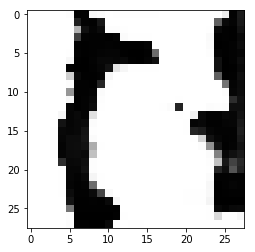

Estimate: [[-15.269927]]
Iteration: 4000 at 2019-07-30 03:50:47.681158


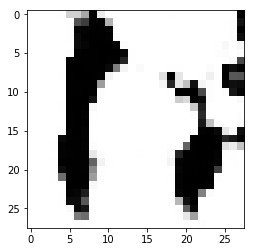

Estimate: [[-8.168685]]
Iteration: 4100 at 2019-07-30 03:52:10.019443


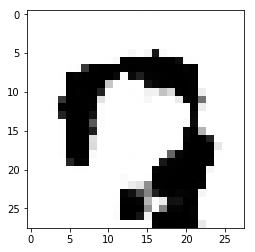

Estimate: [[-8.089236]]
Iteration: 4200 at 2019-07-30 03:53:31.274290


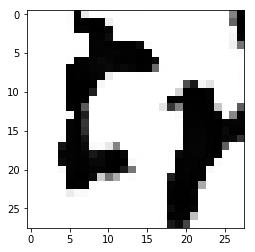

Estimate: [[0.9118531]]
Iteration: 4300 at 2019-07-30 03:54:52.148773


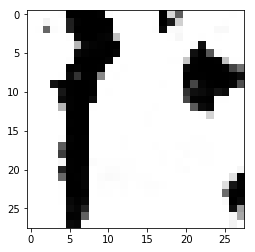

Estimate: [[-14.170549]]
Iteration: 4400 at 2019-07-30 03:56:13.588772


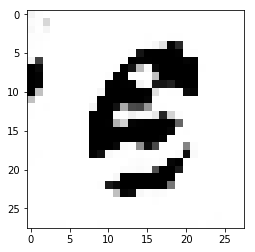

Estimate: [[2.9232628]]
Iteration: 4500 at 2019-07-30 03:57:34.947632


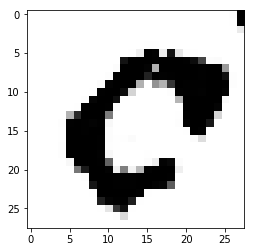

Estimate: [[-7.108414]]
Iteration: 4600 at 2019-07-30 03:58:57.026030


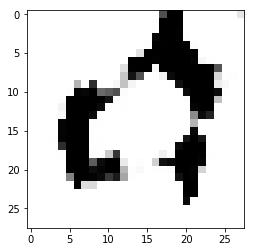

Estimate: [[-1.9217051]]
Iteration: 4700 at 2019-07-30 04:00:18.500166


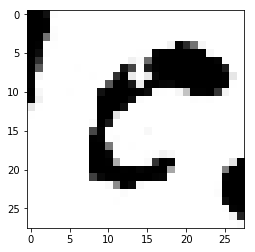

Estimate: [[-9.662952]]
Iteration: 4800 at 2019-07-30 04:01:39.986184


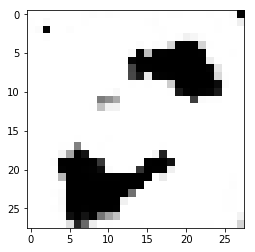

Estimate: [[0.06712664]]
Iteration: 4900 at 2019-07-30 04:03:01.796431


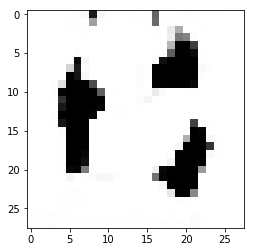

Estimate: [[-10.530057]]
Iteration: 5000 at 2019-07-30 04:04:23.289885


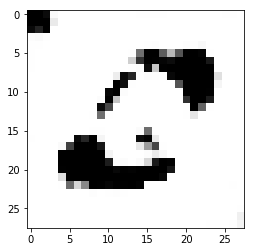

Estimate: [[-4.7382135]]
Iteration: 5100 at 2019-07-30 04:05:45.202767


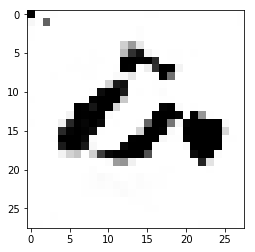

Estimate: [[-1.0357724]]
Iteration: 5200 at 2019-07-30 04:07:07.241699


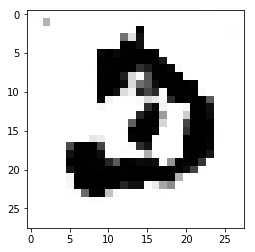

Estimate: [[-1.5397134]]
Iteration: 5300 at 2019-07-30 04:08:30.439073


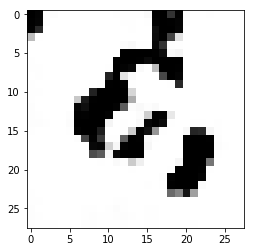

Estimate: [[-4.0073066]]
Iteration: 5400 at 2019-07-30 04:09:53.207310


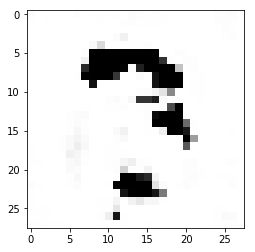

Estimate: [[3.3233402]]
Iteration: 5500 at 2019-07-30 04:11:16.124141


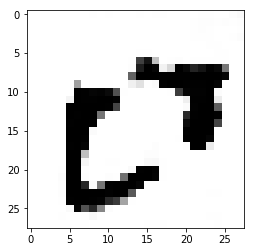

Estimate: [[5.173957]]
Iteration: 5600 at 2019-07-30 04:12:38.926339


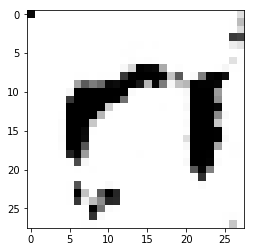

Estimate: [[-4.0499506]]
Iteration: 5700 at 2019-07-30 04:14:02.102654


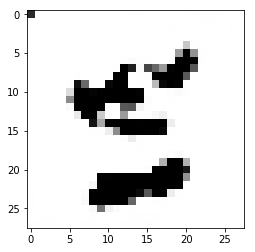

Estimate: [[18.420206]]
Iteration: 5800 at 2019-07-30 04:15:24.895434


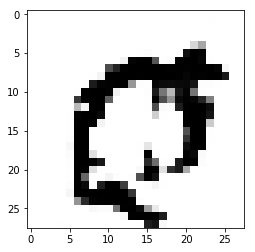

Estimate: [[0.40283158]]
Iteration: 5900 at 2019-07-30 04:16:47.854788


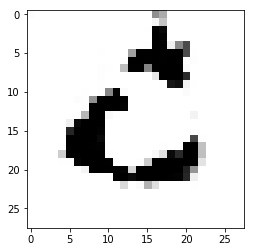

Estimate: [[7.641996]]
Iteration: 6000 at 2019-07-30 04:18:10.395307


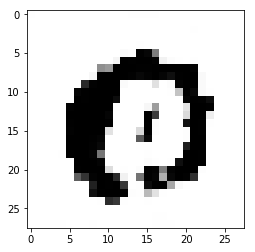

Estimate: [[-6.586497]]
Iteration: 6100 at 2019-07-30 04:19:33.480494


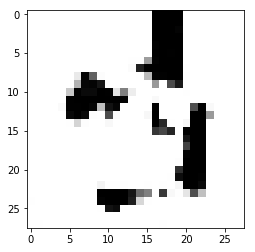

Estimate: [[-7.1315546]]
Iteration: 6200 at 2019-07-30 04:20:56.163103


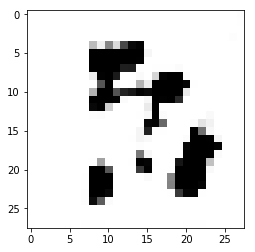

Estimate: [[10.396242]]
Iteration: 6300 at 2019-07-30 04:22:18.639047


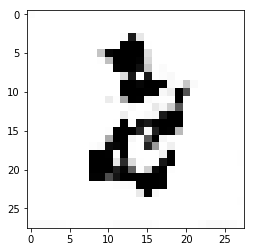

Estimate: [[-4.591849]]
Iteration: 6400 at 2019-07-30 04:23:40.640660


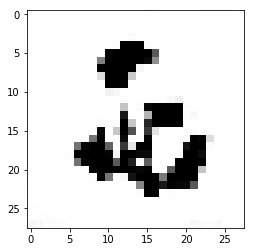

Estimate: [[6.517447]]
Iteration: 6500 at 2019-07-30 04:25:03.226482


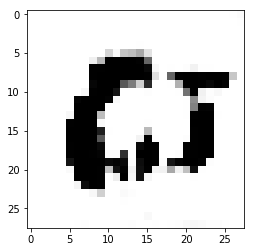

Estimate: [[-5.953991]]
Iteration: 6600 at 2019-07-30 04:26:25.424394


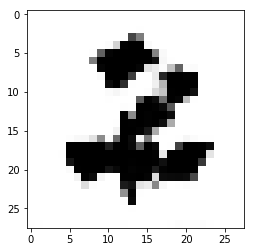

Estimate: [[9.006665]]
Iteration: 6700 at 2019-07-30 04:27:47.370524


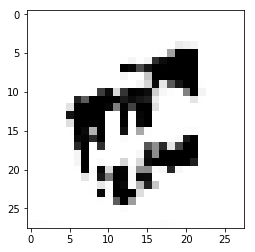

Estimate: [[-5.2662168]]
Iteration: 6800 at 2019-07-30 04:29:09.443467


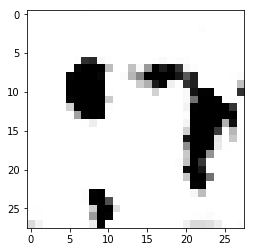

Estimate: [[-14.379723]]
Iteration: 6900 at 2019-07-30 04:30:31.484660


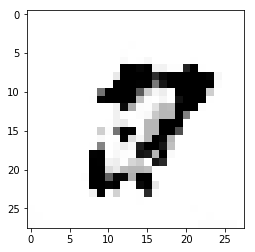

Estimate: [[2.7667882]]
Iteration: 7000 at 2019-07-30 04:31:53.290580


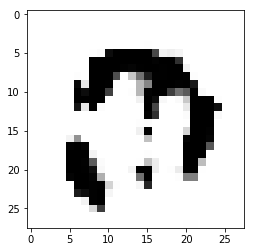

Estimate: [[-0.21927576]]
Iteration: 7100 at 2019-07-30 04:33:15.264214


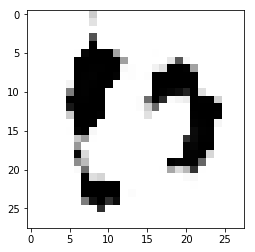

Estimate: [[-10.309014]]
Iteration: 7200 at 2019-07-30 04:34:37.894756


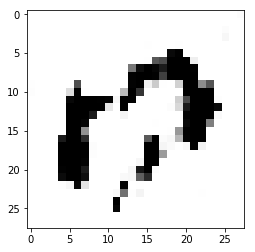

Estimate: [[3.8258772]]
Iteration: 7300 at 2019-07-30 04:35:59.777387


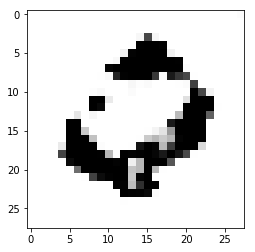

Estimate: [[3.1233284]]
Iteration: 7400 at 2019-07-30 04:37:21.668132


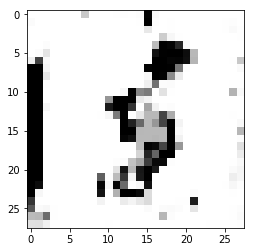

Estimate: [[26.203354]]
Iteration: 7500 at 2019-07-30 04:38:43.617115


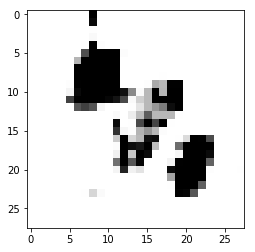

Estimate: [[-13.007052]]
Iteration: 7600 at 2019-07-30 04:40:06.091749


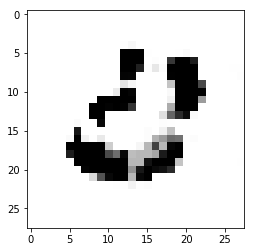

Estimate: [[-7.8773837]]
Iteration: 7700 at 2019-07-30 04:41:28.189826


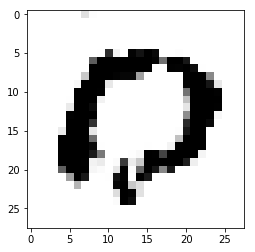

Estimate: [[-26.223583]]
Iteration: 7800 at 2019-07-30 04:42:50.243789


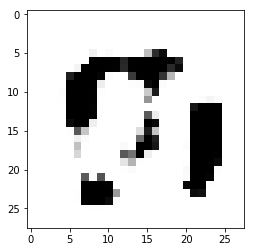

Estimate: [[-6.5788465]]
Iteration: 7900 at 2019-07-30 04:44:12.102708


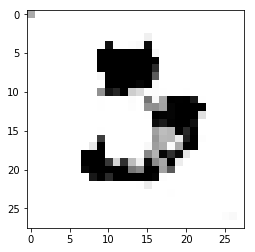

Estimate: [[4.830387]]
Iteration: 8000 at 2019-07-30 04:45:34.159277


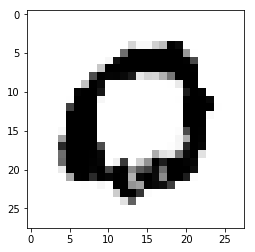

Estimate: [[-1.3048688]]
Iteration: 8100 at 2019-07-30 04:46:55.883137


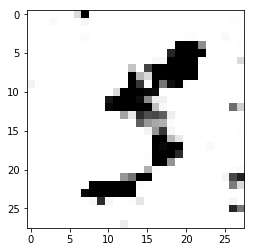

Estimate: [[-4.8353424]]
Iteration: 8200 at 2019-07-30 04:48:17.701192


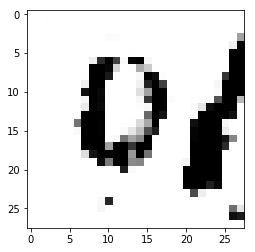

Estimate: [[-11.602606]]
Iteration: 8300 at 2019-07-30 04:49:39.668647


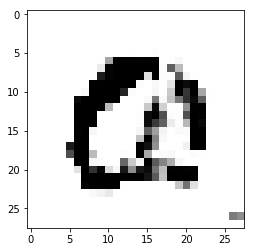

Estimate: [[-4.6390862]]
Iteration: 8400 at 2019-07-30 04:51:02.245661


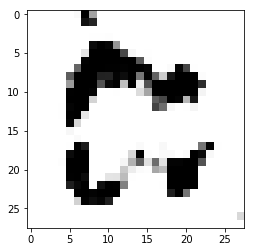

Estimate: [[-32.76946]]
Iteration: 8500 at 2019-07-30 04:52:24.331408


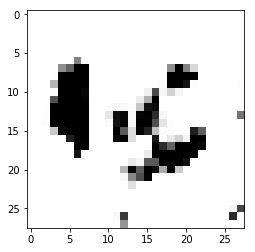

Estimate: [[-9.532265]]
Iteration: 8600 at 2019-07-30 04:53:46.198420


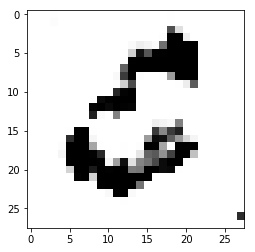

Estimate: [[-8.790345]]
Iteration: 8700 at 2019-07-30 04:55:08.314990


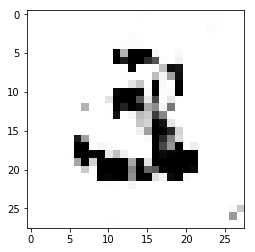

Estimate: [[5.8424845]]
Iteration: 8800 at 2019-07-30 04:56:30.211317


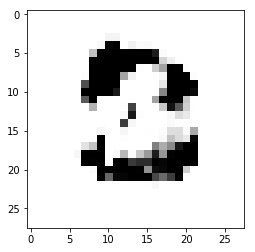

Estimate: [[-7.164586]]
Iteration: 8900 at 2019-07-30 04:57:52.193491


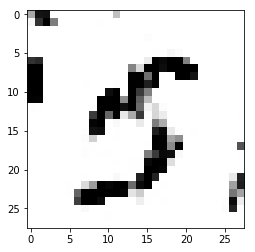

Estimate: [[37.921688]]
Iteration: 9000 at 2019-07-30 04:59:14.008980


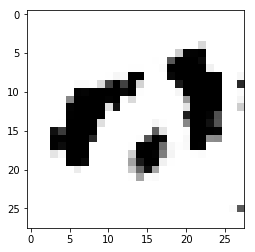

Estimate: [[-14.229248]]
Iteration: 9100 at 2019-07-30 05:00:36.430543


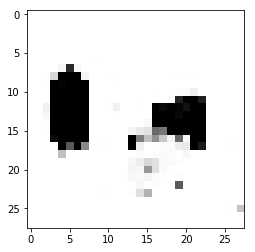

Estimate: [[-6.461075]]
Iteration: 9200 at 2019-07-30 05:01:58.263458


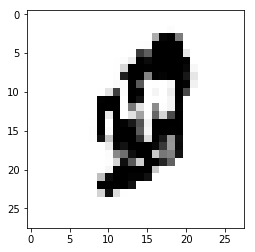

Estimate: [[25.325642]]
Iteration: 9300 at 2019-07-30 05:03:20.356337


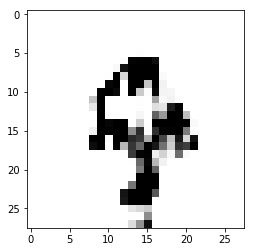

Estimate: [[10.851861]]
Iteration: 9400 at 2019-07-30 05:04:42.268756


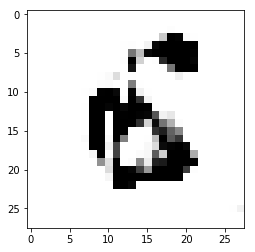

Estimate: [[8.94604]]
Iteration: 9500 at 2019-07-30 05:06:04.416240


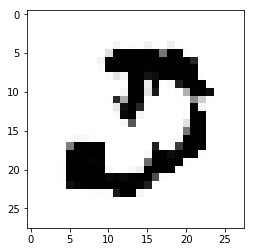

Estimate: [[0.4736086]]
Iteration: 9600 at 2019-07-30 05:07:26.379793


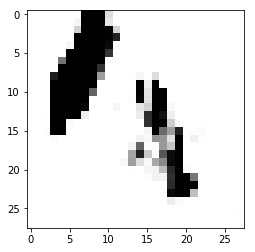

Estimate: [[36.280407]]
Iteration: 9700 at 2019-07-30 05:08:48.295272


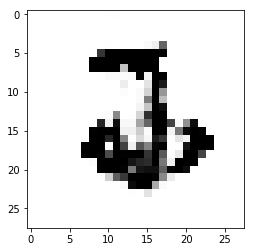

Estimate: [[5.5269694]]
Iteration: 9800 at 2019-07-30 05:10:10.178673


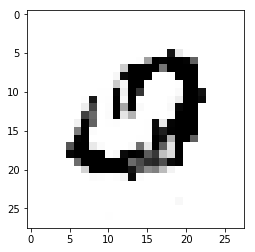

Estimate: [[-10.530404]]
Iteration: 9900 at 2019-07-30 05:11:32.459829


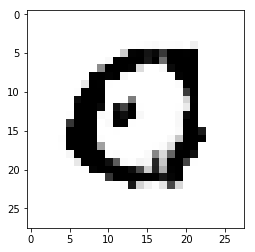

Estimate: [[-9.286342]]
Iteration: 10000 at 2019-07-30 05:12:54.432405


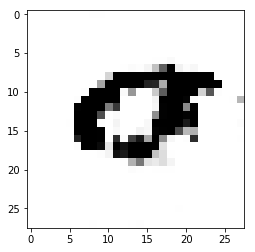

Estimate: [[-3.3294325]]
Iteration: 10100 at 2019-07-30 05:14:16.699343


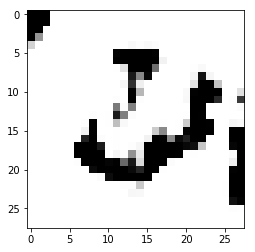

Estimate: [[-5.3961034]]
Iteration: 10200 at 2019-07-30 05:15:39.170042


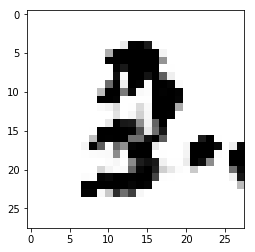

Estimate: [[11.536833]]
Iteration: 10300 at 2019-07-30 05:17:00.907232


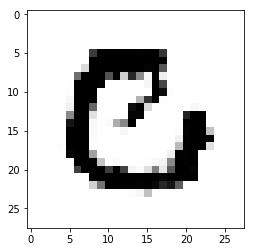

Estimate: [[-11.674771]]
Iteration: 10400 at 2019-07-30 05:18:22.702172


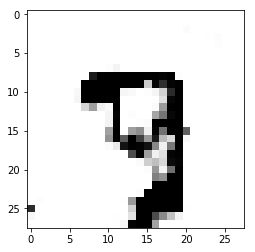

Estimate: [[8.44074]]
Iteration: 10500 at 2019-07-30 05:19:44.229196


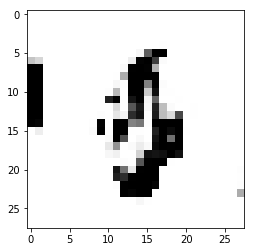

Estimate: [[47.36179]]
Iteration: 10600 at 2019-07-30 05:21:06.423324


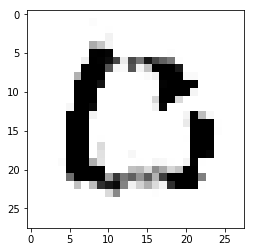

Estimate: [[-0.7371615]]
Iteration: 10700 at 2019-07-30 05:22:28.198038


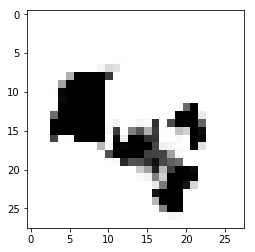

Estimate: [[-9.165851]]
Iteration: 10800 at 2019-07-30 05:23:49.831913


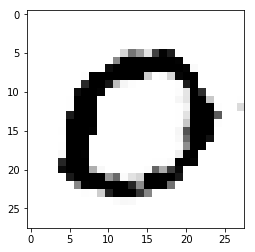

Estimate: [[16.307446]]
Iteration: 10900 at 2019-07-30 05:25:11.631506


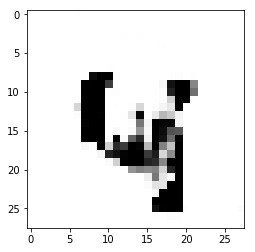

Estimate: [[-27.22568]]
Iteration: 11000 at 2019-07-30 05:26:33.365228


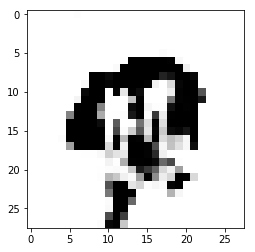

Estimate: [[-3.5098639]]
Iteration: 11100 at 2019-07-30 05:27:54.852230


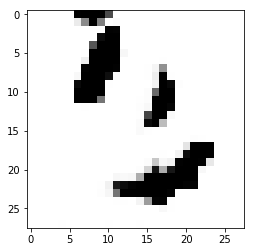

Estimate: [[13.030646]]
Iteration: 11200 at 2019-07-30 05:29:16.263683


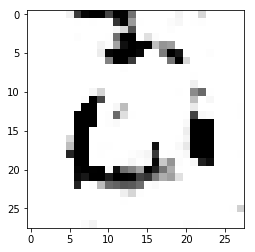

Estimate: [[-9.86635]]
Iteration: 11300 at 2019-07-30 05:30:38.211738


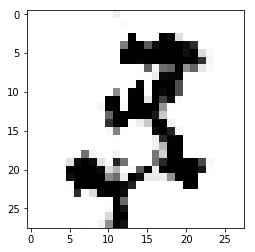

Estimate: [[-6.0545635]]
Iteration: 11400 at 2019-07-30 05:31:59.751691


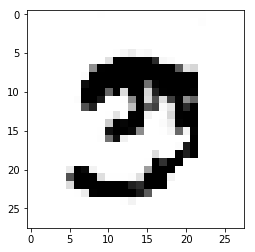

Estimate: [[7.197064]]
Iteration: 11500 at 2019-07-30 05:33:21.433673


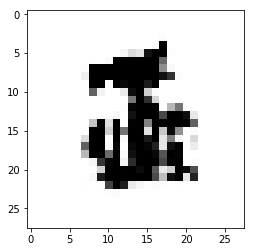

Estimate: [[7.169286]]
Iteration: 11600 at 2019-07-30 05:34:42.851151


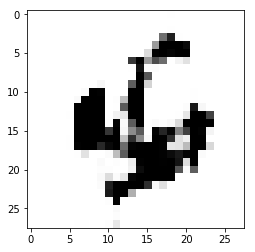

Estimate: [[-3.4507961]]
Iteration: 11700 at 2019-07-30 05:36:04.774961


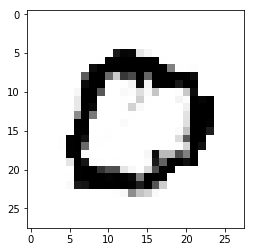

Estimate: [[-13.171851]]
Iteration: 11800 at 2019-07-30 05:37:26.602610


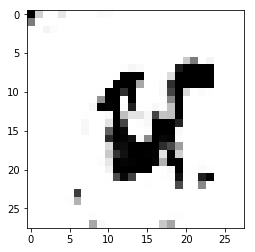

Estimate: [[-40.333416]]
Iteration: 11900 at 2019-07-30 05:38:48.277767


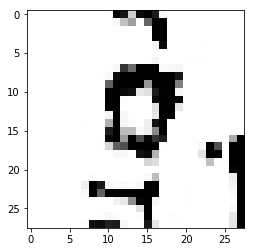

Estimate: [[4.3091216]]
Iteration: 12000 at 2019-07-30 05:40:09.903309


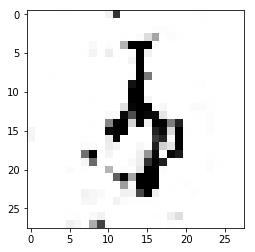

Estimate: [[-19.181427]]
Iteration: 12100 at 2019-07-30 05:41:31.719950


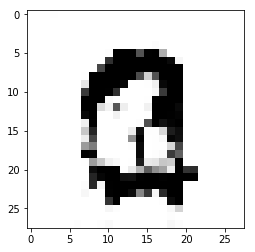

Estimate: [[-29.99463]]
Iteration: 12200 at 2019-07-30 05:42:53.379282


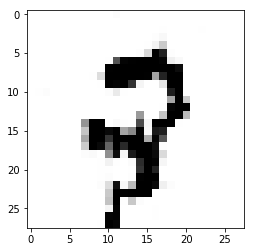

Estimate: [[3.4111223]]
Iteration: 12300 at 2019-07-30 05:44:14.894513


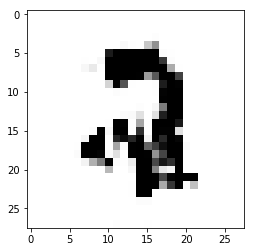

Estimate: [[-4.6104975]]
Iteration: 12400 at 2019-07-30 05:45:36.657330


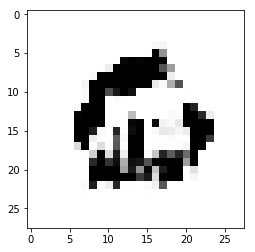

Estimate: [[2.336303]]
Iteration: 12500 at 2019-07-30 05:46:58.425827


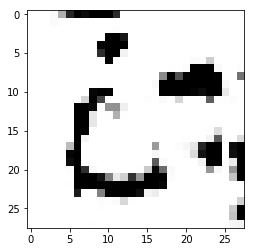

Estimate: [[3.6790187]]
Iteration: 12600 at 2019-07-30 05:48:20.012363


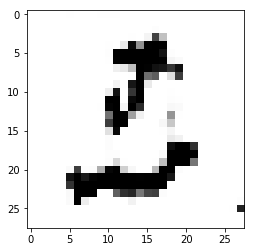

Estimate: [[-24.802671]]
Iteration: 12700 at 2019-07-30 05:49:41.778752


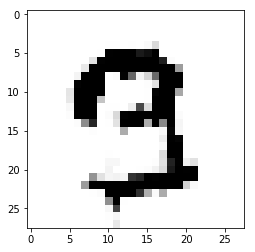

Estimate: [[-14.090035]]
Iteration: 12800 at 2019-07-30 05:51:03.605277


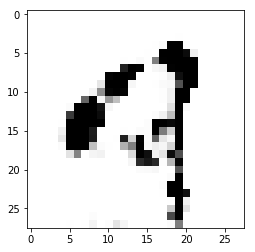

Estimate: [[-7.9078107]]
Iteration: 12900 at 2019-07-30 05:52:25.951704


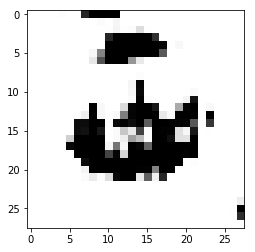

Estimate: [[25.11535]]
Iteration: 13000 at 2019-07-30 05:53:47.542343


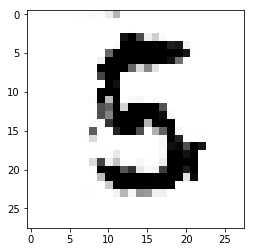

Estimate: [[13.641924]]
Iteration: 13100 at 2019-07-30 05:55:09.160406


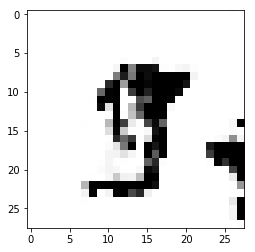

Estimate: [[7.891559]]
Iteration: 13200 at 2019-07-30 05:56:30.958694


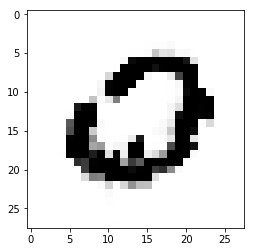

Estimate: [[-18.02436]]
Iteration: 13300 at 2019-07-30 05:57:52.745163


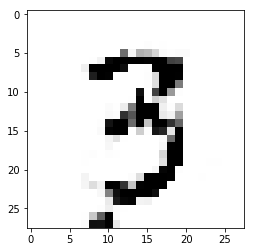

Estimate: [[10.070982]]
Iteration: 13400 at 2019-07-30 05:59:14.585533


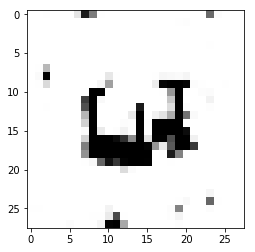

Estimate: [[-43.590054]]
Iteration: 13500 at 2019-07-30 06:00:36.273810


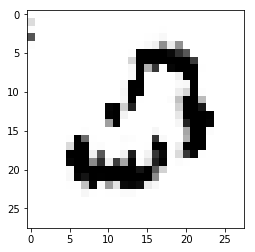

Estimate: [[-25.380615]]
Iteration: 13600 at 2019-07-30 06:01:58.151534


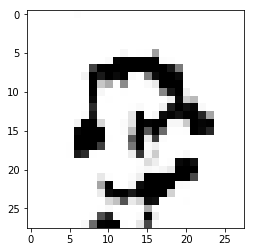

Estimate: [[1.4154254]]
Iteration: 13700 at 2019-07-30 06:03:19.560795


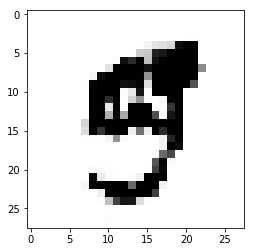

Estimate: [[5.6894403]]
Iteration: 13800 at 2019-07-30 06:04:40.787571


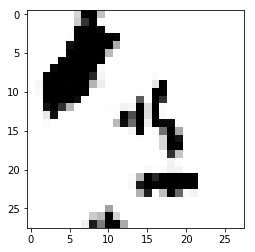

Estimate: [[106.5954]]
Iteration: 13900 at 2019-07-30 06:06:01.723780


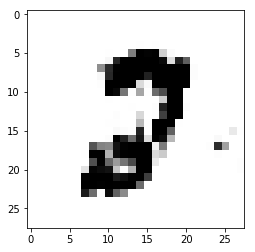

Estimate: [[-9.35165]]
Iteration: 14000 at 2019-07-30 06:07:22.913038


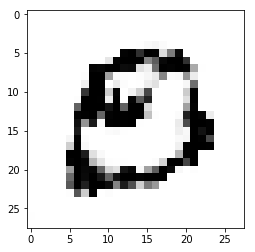

Estimate: [[-13.143877]]
Iteration: 14100 at 2019-07-30 06:08:44.257197


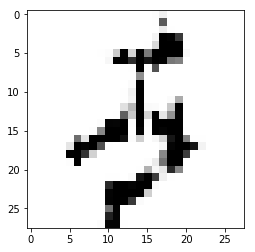

Estimate: [[8.658695]]
Iteration: 14200 at 2019-07-30 06:10:05.432799


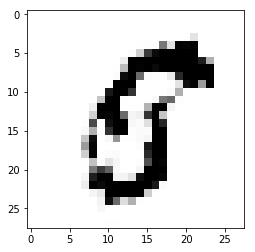

Estimate: [[20.122929]]
Iteration: 14300 at 2019-07-30 06:11:26.934443


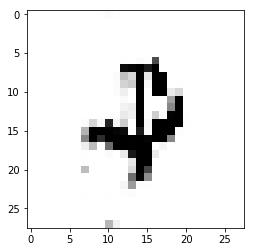

Estimate: [[14.262764]]
Iteration: 14400 at 2019-07-30 06:12:48.726171


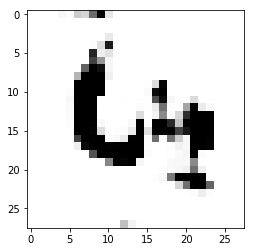

Estimate: [[5.0385995]]
Iteration: 14500 at 2019-07-30 06:14:10.143739


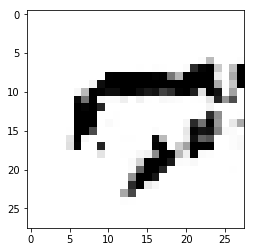

Estimate: [[3.0168986]]
Iteration: 14600 at 2019-07-30 06:15:31.695639


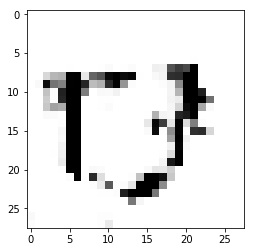

Estimate: [[-34.08561]]
Iteration: 14700 at 2019-07-30 06:16:53.156074


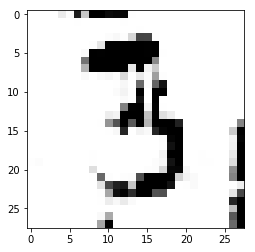

Estimate: [[37.04571]]
Iteration: 14800 at 2019-07-30 06:18:14.665049


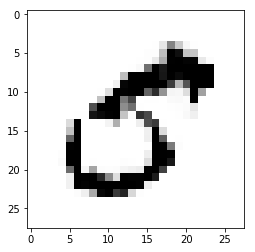

Estimate: [[17.230774]]
Iteration: 14900 at 2019-07-30 06:19:36.052741


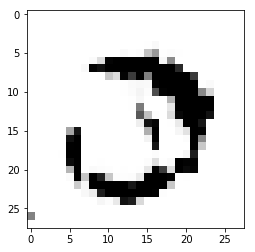

Estimate: [[-10.644073]]
Iteration: 15000 at 2019-07-30 06:20:57.599847


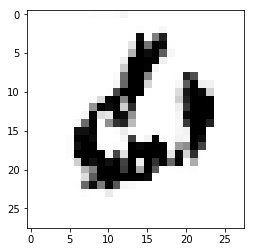

Estimate: [[6.5037446]]
Iteration: 15100 at 2019-07-30 06:22:19.358446


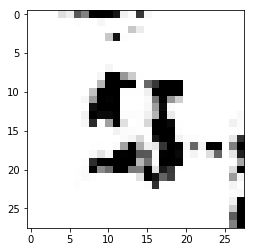

Estimate: [[22.192492]]
Iteration: 15200 at 2019-07-30 06:23:40.791105


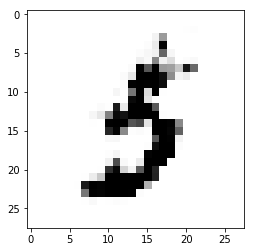

Estimate: [[-11.159138]]
Iteration: 15300 at 2019-07-30 06:25:01.855648


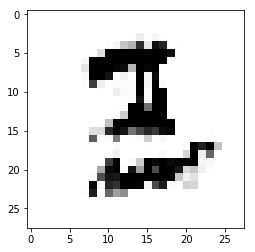

Estimate: [[4.242363]]
Iteration: 15400 at 2019-07-30 06:26:23.138678


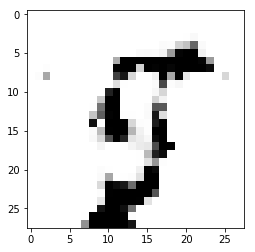

Estimate: [[-28.191494]]
Iteration: 15500 at 2019-07-30 06:27:44.393352


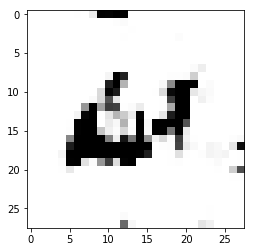

Estimate: [[-20.960314]]
Iteration: 15600 at 2019-07-30 06:29:05.891524


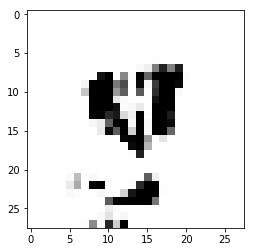

Estimate: [[4.306175]]
Iteration: 15700 at 2019-07-30 06:30:27.217007


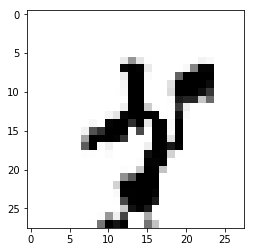

Estimate: [[-17.37205]]
Iteration: 15800 at 2019-07-30 06:31:48.669410


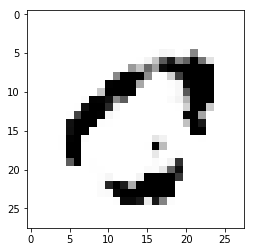

Estimate: [[27.64849]]
Iteration: 15900 at 2019-07-30 06:33:10.203512


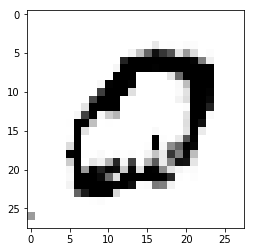

Estimate: [[47.63486]]
Iteration: 16000 at 2019-07-30 06:34:32.054138


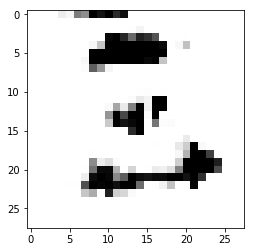

Estimate: [[9.798667]]
Iteration: 16100 at 2019-07-30 06:35:53.740518


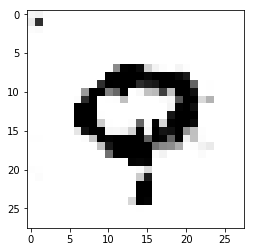

Estimate: [[-9.779599]]
Iteration: 16200 at 2019-07-30 06:37:15.667161


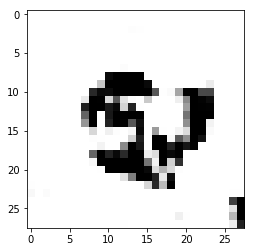

Estimate: [[8.555661]]
Iteration: 16300 at 2019-07-30 06:38:37.358895


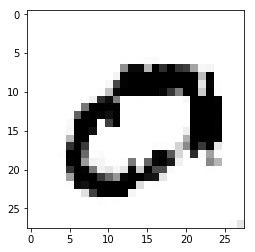

Estimate: [[-6.869185]]
Iteration: 16400 at 2019-07-30 06:39:58.942854


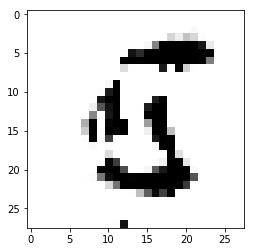

Estimate: [[6.4497366]]
Iteration: 16500 at 2019-07-30 06:41:20.597136


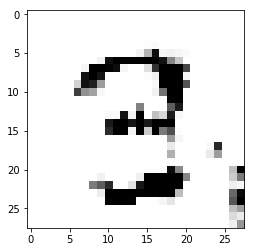

Estimate: [[-14.181628]]
Iteration: 16600 at 2019-07-30 06:42:42.154164


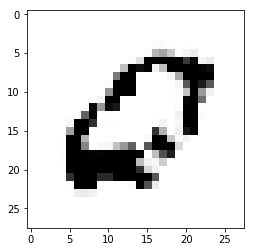

Estimate: [[8.074883]]
Iteration: 16700 at 2019-07-30 06:44:03.928913


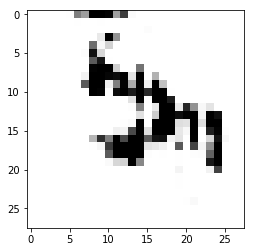

Estimate: [[-8.634026]]
Iteration: 16800 at 2019-07-30 06:45:25.445030


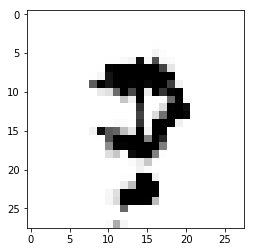

Estimate: [[6.87665]]
Iteration: 16900 at 2019-07-30 06:46:46.947734


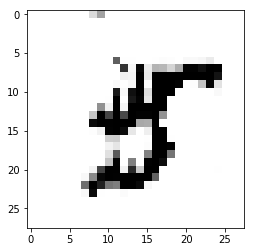

Estimate: [[74.70107]]
Iteration: 17000 at 2019-07-30 06:48:08.299272


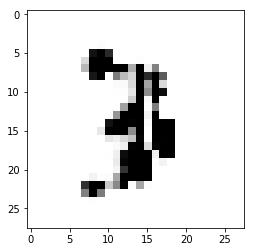

Estimate: [[36.088238]]
Iteration: 17100 at 2019-07-30 06:49:29.965649


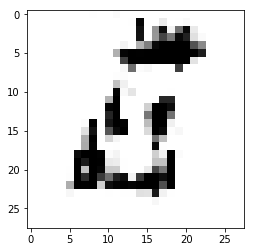

Estimate: [[6.6037116]]
Iteration: 17200 at 2019-07-30 06:50:51.642272


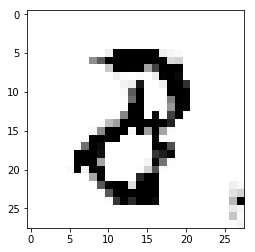

Estimate: [[43.72809]]
Iteration: 17300 at 2019-07-30 06:52:13.924756


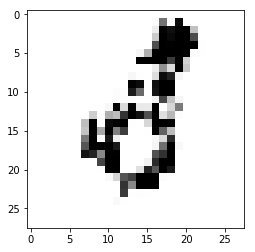

Estimate: [[44.913124]]
Iteration: 17400 at 2019-07-30 06:53:35.742223


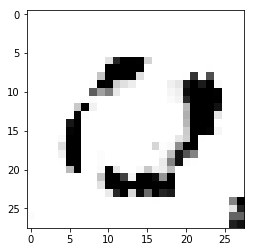

Estimate: [[-15.801821]]
Iteration: 17500 at 2019-07-30 06:54:57.935927


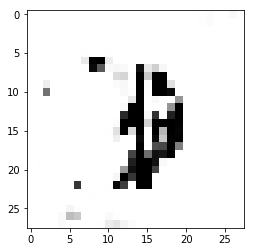

Estimate: [[-101.98183]]
Iteration: 17600 at 2019-07-30 06:56:19.777900


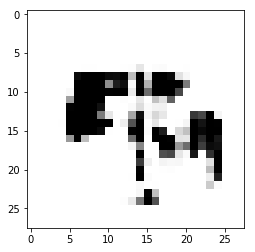

Estimate: [[32.26118]]
Iteration: 17700 at 2019-07-30 06:57:41.829661


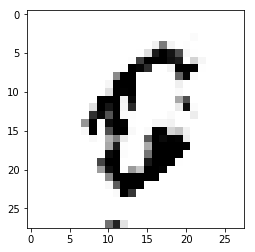

Estimate: [[-2.001688]]
Iteration: 17800 at 2019-07-30 06:59:03.741152


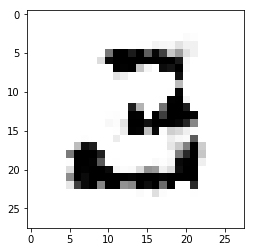

Estimate: [[-77.63011]]
Iteration: 17900 at 2019-07-30 07:00:25.932996


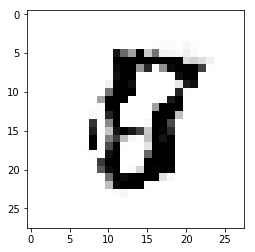

Estimate: [[76.42905]]
Iteration: 18000 at 2019-07-30 07:01:48.087019


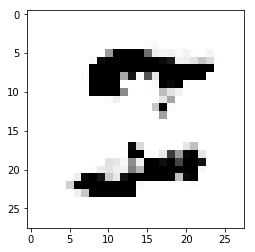

Estimate: [[5.379978]]
Iteration: 18100 at 2019-07-30 07:03:10.425129


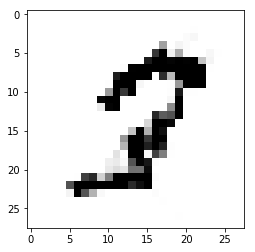

Estimate: [[19.731302]]
Iteration: 18200 at 2019-07-30 07:04:32.677223


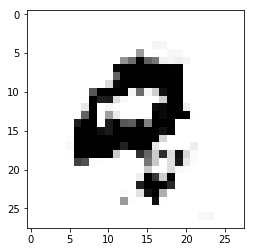

Estimate: [[4.8301206]]
Iteration: 18300 at 2019-07-30 07:05:55.018316


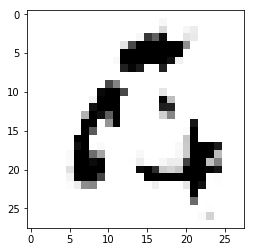

Estimate: [[33.71663]]
Iteration: 18400 at 2019-07-30 07:07:17.330897


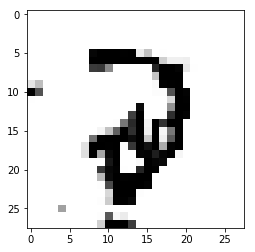

Estimate: [[-8.374139]]
Iteration: 18500 at 2019-07-30 07:08:40.058808


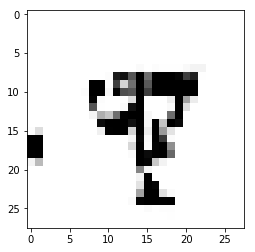

Estimate: [[28.580387]]
Iteration: 18600 at 2019-07-30 07:10:02.396050


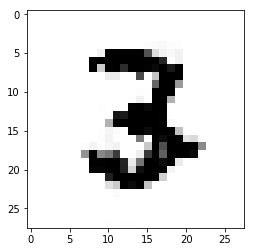

Estimate: [[4.9114513]]
Iteration: 18700 at 2019-07-30 07:11:24.703213


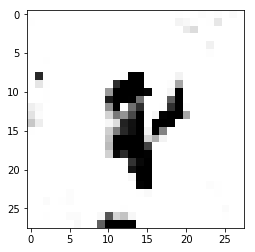

Estimate: [[-96.17077]]
Iteration: 18800 at 2019-07-30 07:12:47.083895


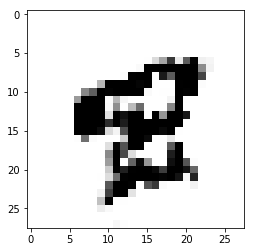

Estimate: [[-5.8272758]]
Iteration: 18900 at 2019-07-30 07:14:09.211683


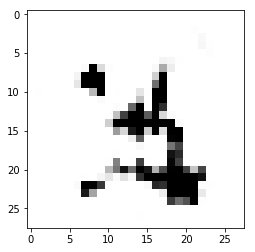

Estimate: [[39.089424]]
Iteration: 19000 at 2019-07-30 07:15:31.831263


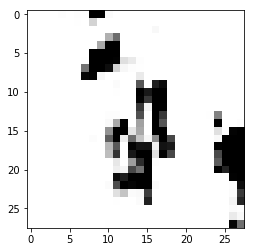

Estimate: [[135.53072]]
Iteration: 19100 at 2019-07-30 07:16:54.011718


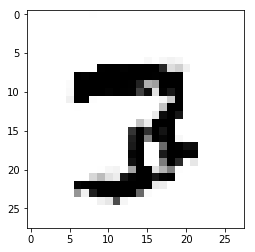

Estimate: [[15.971477]]
Iteration: 19200 at 2019-07-30 07:18:16.492642


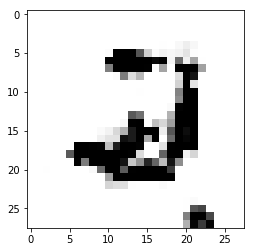

Estimate: [[-37.194824]]
Iteration: 19300 at 2019-07-30 07:19:38.609616


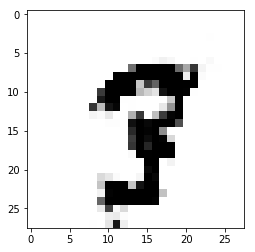

Estimate: [[-62.054806]]
Iteration: 19400 at 2019-07-30 07:21:00.949598


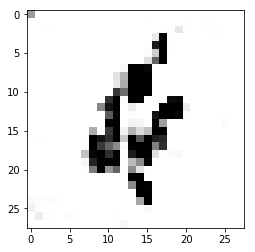

Estimate: [[-42.661488]]
Iteration: 19500 at 2019-07-30 07:22:23.163625


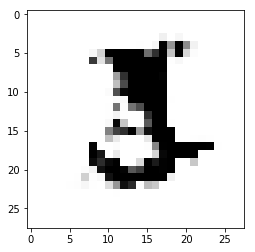

Estimate: [[-34.654343]]
Iteration: 19600 at 2019-07-30 07:23:45.301832


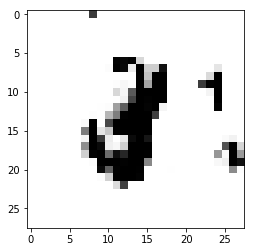

Estimate: [[37.787586]]
Iteration: 19700 at 2019-07-30 07:25:07.396804


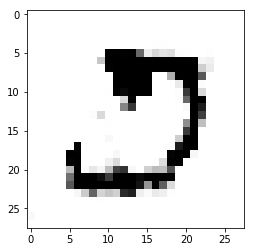

Estimate: [[74.33578]]
Iteration: 19800 at 2019-07-30 07:26:29.743123


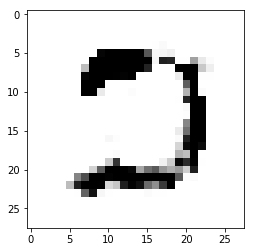

Estimate: [[35.29634]]
Iteration: 19900 at 2019-07-30 07:27:52.138814


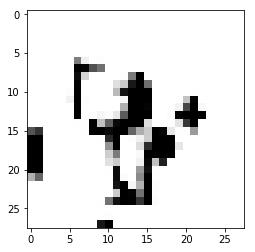

Estimate: [[12.397031]]
Iteration: 20000 at 2019-07-30 07:29:14.561435


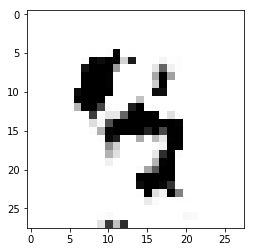

Estimate: [[-40.574608]]
Iteration: 20100 at 2019-07-30 07:30:37.145318


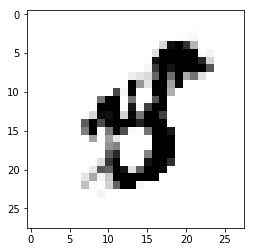

Estimate: [[16.638296]]
Iteration: 20200 at 2019-07-30 07:32:01.223015


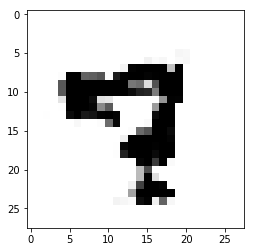

Estimate: [[-29.813885]]
Iteration: 20300 at 2019-07-30 07:33:24.415362


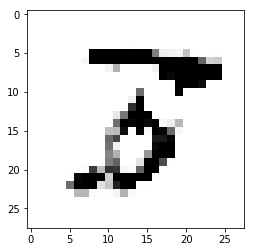

Estimate: [[11.71648]]
Iteration: 20400 at 2019-07-30 07:34:47.115220


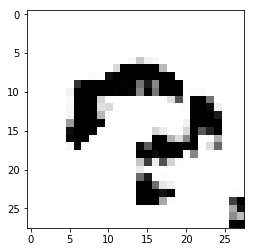

Estimate: [[5.856241]]
Iteration: 20500 at 2019-07-30 07:36:09.776836


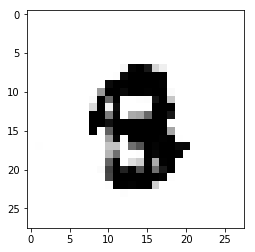

Estimate: [[38.647694]]
Iteration: 20600 at 2019-07-30 07:37:32.471454


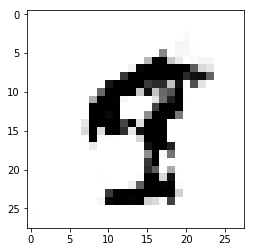

Estimate: [[-28.906796]]
Iteration: 20700 at 2019-07-30 07:38:55.185864


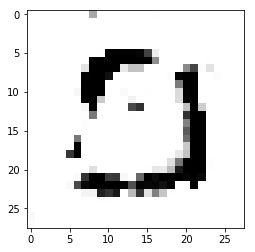

Estimate: [[-12.203656]]
Iteration: 20800 at 2019-07-30 07:40:17.958282


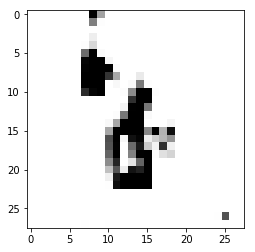

Estimate: [[36.20683]]
Iteration: 20900 at 2019-07-30 07:41:40.785139


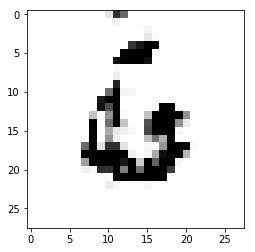

Estimate: [[1.3125567]]
Iteration: 21000 at 2019-07-30 07:43:03.886417


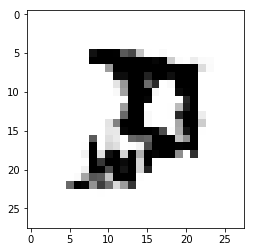

Estimate: [[1.602001]]
Iteration: 21100 at 2019-07-30 07:44:26.736544


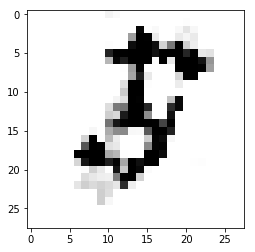

Estimate: [[-36.211124]]
Iteration: 21200 at 2019-07-30 07:45:49.438230


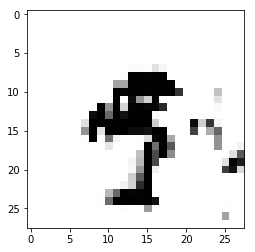

Estimate: [[-19.358473]]
Iteration: 21300 at 2019-07-30 07:47:11.832682


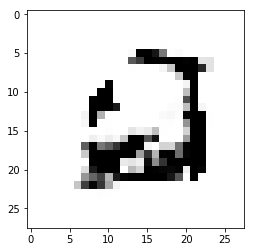

Estimate: [[9.524768]]
Iteration: 21400 at 2019-07-30 07:48:34.136998


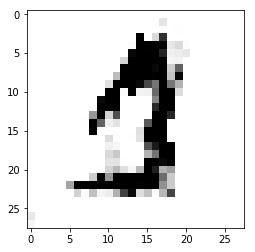

Estimate: [[-4.57017]]
Iteration: 21500 at 2019-07-30 07:49:56.538534


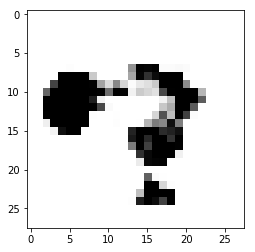

Estimate: [[45.294914]]
Iteration: 21600 at 2019-07-30 07:51:18.953136


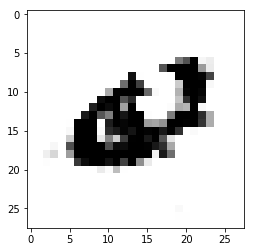

Estimate: [[13.147619]]
Iteration: 21700 at 2019-07-30 07:52:41.540782


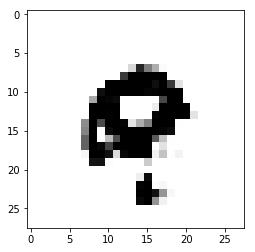

Estimate: [[-7.6555257]]
Iteration: 21800 at 2019-07-30 07:54:03.775803


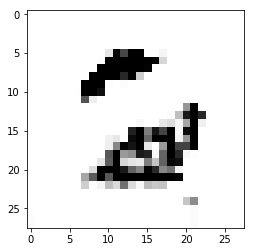

Estimate: [[10.648928]]
Iteration: 21900 at 2019-07-30 07:55:26.116986


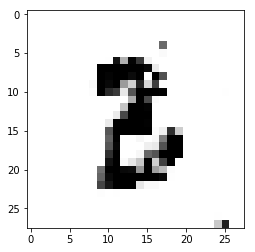

Estimate: [[38.593792]]
Iteration: 22000 at 2019-07-30 07:56:48.447810


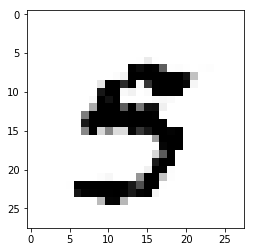

Estimate: [[25.298885]]
Iteration: 22100 at 2019-07-30 07:58:10.821493


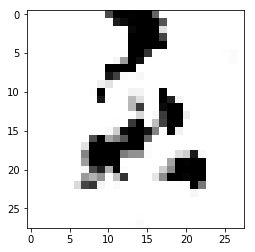

Estimate: [[19.801016]]
Iteration: 22200 at 2019-07-30 07:59:33.198080


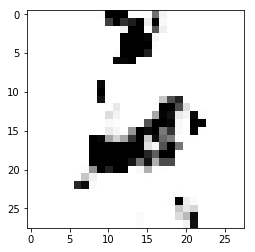

Estimate: [[35.495304]]
Iteration: 22300 at 2019-07-30 08:00:55.952986


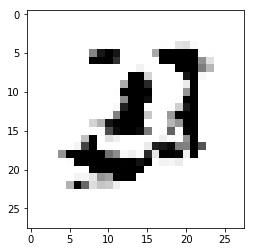

Estimate: [[57.041973]]
Iteration: 22400 at 2019-07-30 08:02:18.646624


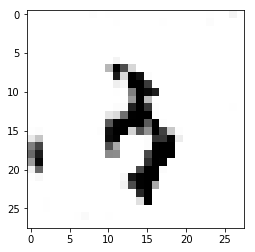

Estimate: [[-30.910484]]
Iteration: 22500 at 2019-07-30 08:03:41.141814


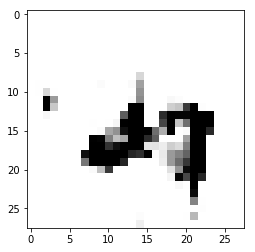

Estimate: [[-30.323307]]
Iteration: 22600 at 2019-07-30 08:05:03.725092


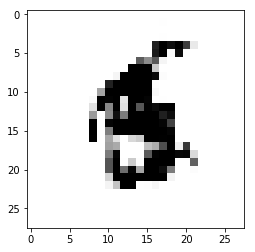

Estimate: [[65.76334]]
Iteration: 22700 at 2019-07-30 08:06:26.388936


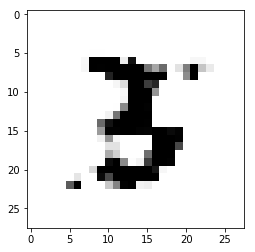

Estimate: [[44.92281]]
Iteration: 22800 at 2019-07-30 08:07:48.966537


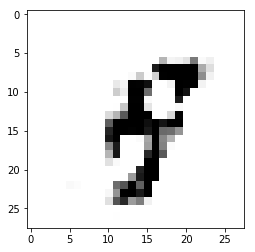

Estimate: [[-25.247774]]
Iteration: 22900 at 2019-07-30 08:09:11.692932


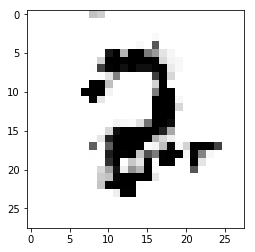

Estimate: [[-8.014339]]
Iteration: 23000 at 2019-07-30 08:10:34.334827


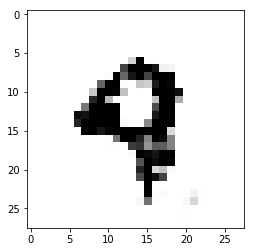

Estimate: [[-26.604225]]
Iteration: 23100 at 2019-07-30 08:11:56.748217


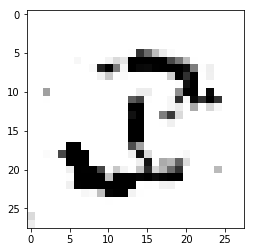

Estimate: [[-34.587498]]
Iteration: 23200 at 2019-07-30 08:13:19.025148


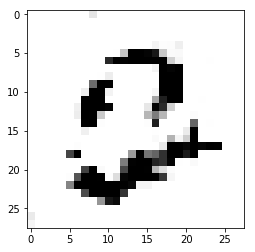

Estimate: [[41.570015]]
Iteration: 23300 at 2019-07-30 08:14:41.480214


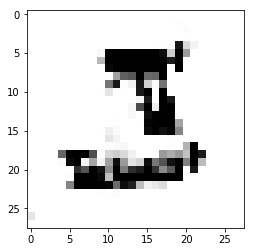

Estimate: [[19.15746]]
Iteration: 23400 at 2019-07-30 08:16:03.704956


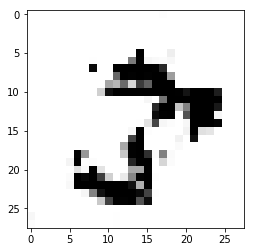

Estimate: [[0.6033331]]
Iteration: 23500 at 2019-07-30 08:17:26.379023


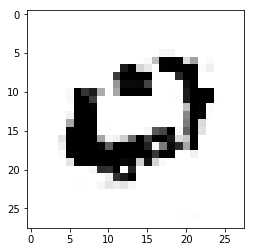

Estimate: [[50.8449]]
Iteration: 23600 at 2019-07-30 08:18:48.974225


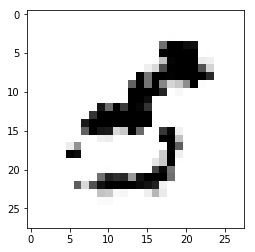

Estimate: [[28.997444]]
Iteration: 23700 at 2019-07-30 08:20:11.541464


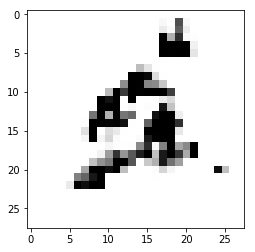

Estimate: [[-2.5974028]]
Iteration: 23800 at 2019-07-30 08:21:34.222327


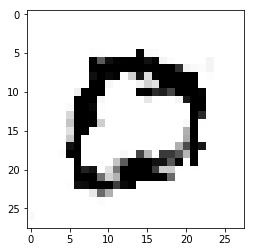

Estimate: [[-55.116478]]
Iteration: 23900 at 2019-07-30 08:22:56.646947


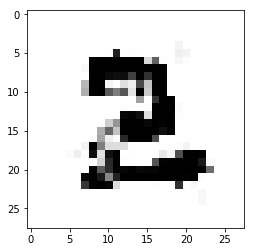

Estimate: [[-30.970816]]
Iteration: 24000 at 2019-07-30 08:24:19.305360


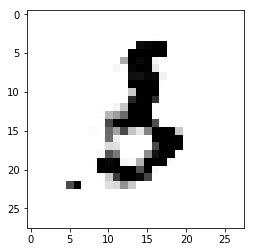

Estimate: [[-6.205929]]
Iteration: 24100 at 2019-07-30 08:25:41.783818


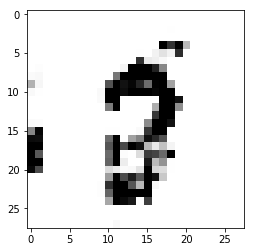

Estimate: [[51.598385]]
Iteration: 24200 at 2019-07-30 08:27:04.036279


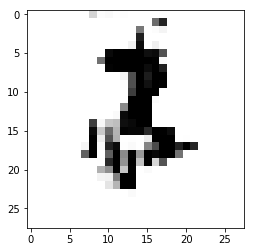

Estimate: [[32.664753]]
Iteration: 24300 at 2019-07-30 08:28:26.481304


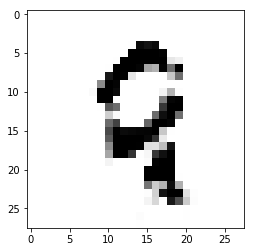

Estimate: [[15.138327]]
Iteration: 24400 at 2019-07-30 08:29:48.996302


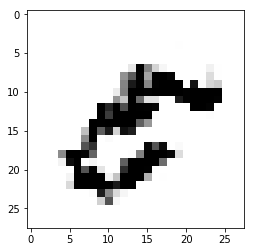

Estimate: [[50.375416]]
Iteration: 24500 at 2019-07-30 08:31:11.720732


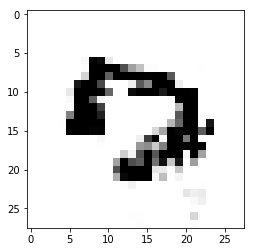

Estimate: [[-31.65851]]
Iteration: 24600 at 2019-07-30 08:32:34.627894


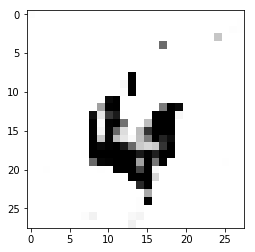

Estimate: [[-19.81776]]
Iteration: 24700 at 2019-07-30 08:33:58.121574


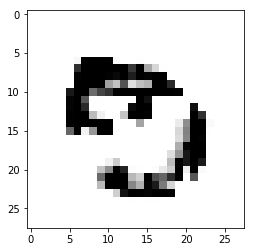

Estimate: [[81.94072]]
Iteration: 24800 at 2019-07-30 08:35:21.771649


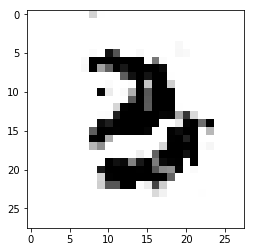

Estimate: [[36.235672]]
Iteration: 24900 at 2019-07-30 08:36:45.409841


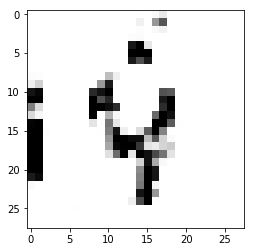

Estimate: [[167.32188]]
Iteration: 25000 at 2019-07-30 08:38:09.129028


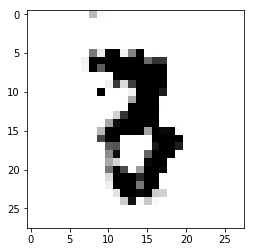

Estimate: [[-39.629128]]
Iteration: 25100 at 2019-07-30 08:39:32.357200


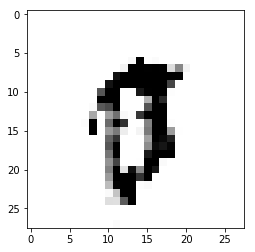

Estimate: [[-44.49226]]
Iteration: 25200 at 2019-07-30 08:40:55.571784


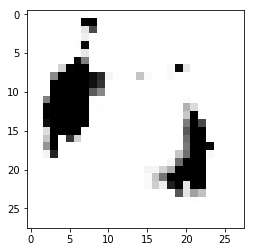

Estimate: [[229.73906]]
Iteration: 25300 at 2019-07-30 08:42:18.313621


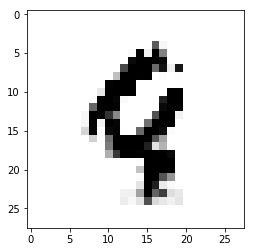

Estimate: [[25.474346]]
Iteration: 25400 at 2019-07-30 08:43:41.698425


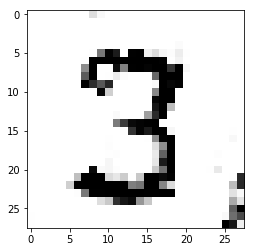

Estimate: [[-18.03791]]
Iteration: 25500 at 2019-07-30 08:45:05.171872


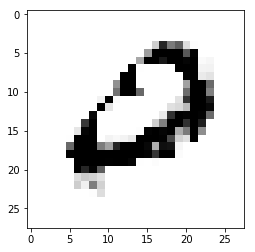

Estimate: [[31.935635]]
Iteration: 25600 at 2019-07-30 08:46:28.896526


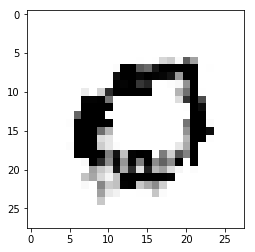

Estimate: [[24.832985]]
Iteration: 25700 at 2019-07-30 08:47:52.533088


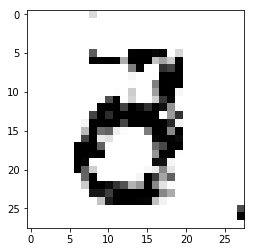

Estimate: [[4.9095387]]
Iteration: 25800 at 2019-07-30 08:49:16.336159


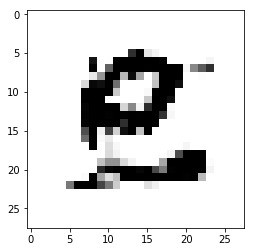

Estimate: [[36.59737]]
Iteration: 25900 at 2019-07-30 08:50:39.497038


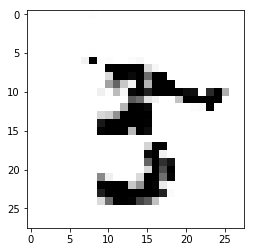

Estimate: [[-0.45048994]]
Iteration: 26000 at 2019-07-30 08:52:02.894846


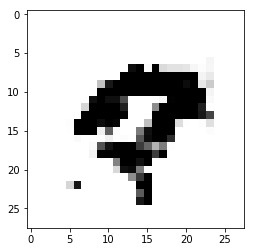

Estimate: [[-25.589037]]
Iteration: 26100 at 2019-07-30 08:53:26.286515


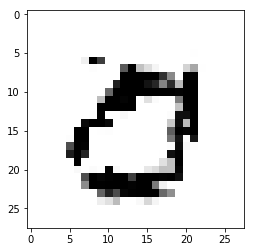

Estimate: [[-9.201019]]
Iteration: 26200 at 2019-07-30 08:54:49.827711


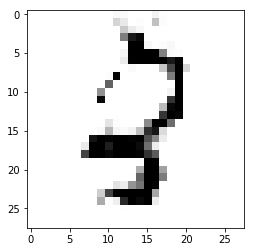

Estimate: [[6.6697774]]
Iteration: 26300 at 2019-07-30 08:56:13.141310


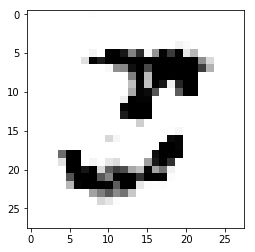

Estimate: [[34.043056]]
Iteration: 26400 at 2019-07-30 08:57:36.280589


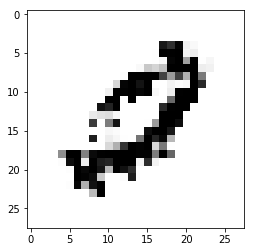

Estimate: [[-13.764281]]
Iteration: 26500 at 2019-07-30 08:58:59.765670


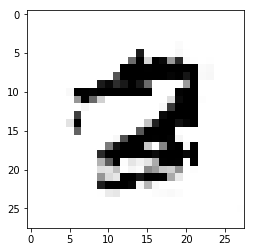

Estimate: [[14.228447]]
Iteration: 26600 at 2019-07-30 09:00:23.050026


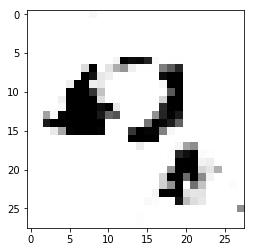

Estimate: [[-58.41583]]
Iteration: 26700 at 2019-07-30 09:01:46.606983


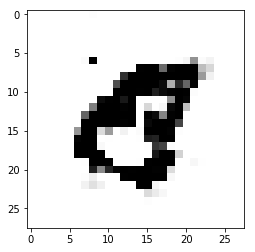

Estimate: [[-12.30098]]
Iteration: 26800 at 2019-07-30 09:03:10.101296


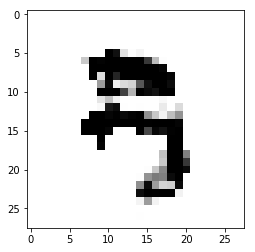

Estimate: [[-12.425965]]
Iteration: 26900 at 2019-07-30 09:04:33.712428


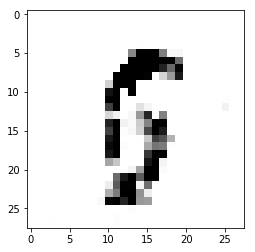

Estimate: [[-7.1682653]]
Iteration: 27000 at 2019-07-30 09:05:57.391257


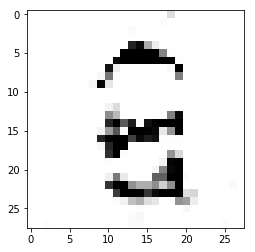

Estimate: [[-12.434617]]
Iteration: 27100 at 2019-07-30 09:07:21.124146


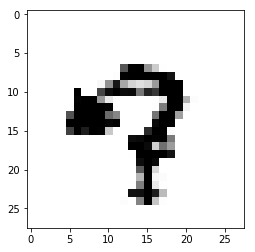

Estimate: [[32.713524]]
Iteration: 27200 at 2019-07-30 09:08:44.846472


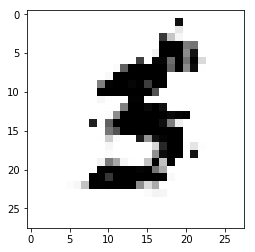

Estimate: [[-23.839594]]
Iteration: 27300 at 2019-07-30 09:10:08.821544


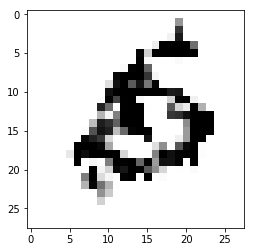

Estimate: [[81.76163]]
Iteration: 27400 at 2019-07-30 09:11:31.954607


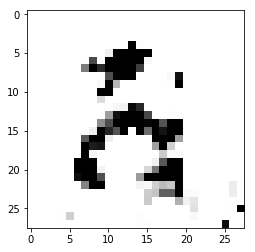

Estimate: [[12.524062]]
Iteration: 27500 at 2019-07-30 09:12:55.181608


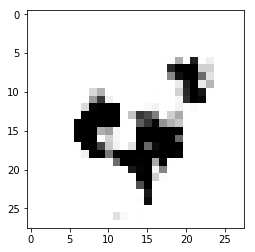

Estimate: [[-15.387713]]
Iteration: 27600 at 2019-07-30 09:14:18.430561


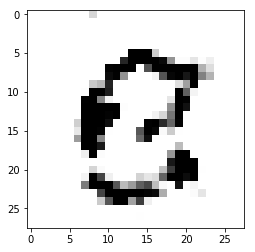

Estimate: [[-6.6425886]]
Iteration: 27700 at 2019-07-30 09:15:42.516455


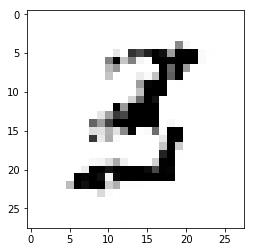

Estimate: [[23.749338]]
Iteration: 27800 at 2019-07-30 09:17:06.473766


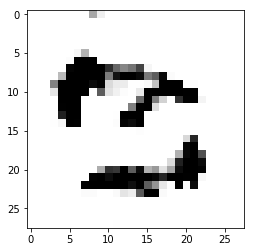

Estimate: [[-32.717823]]
Iteration: 27900 at 2019-07-30 09:18:30.470471


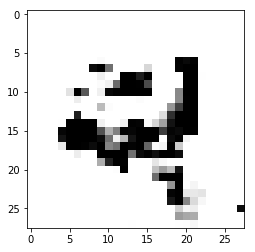

Estimate: [[56.094997]]
Iteration: 28000 at 2019-07-30 09:19:54.780222


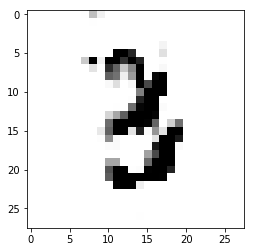

Estimate: [[12.563839]]
Iteration: 28100 at 2019-07-30 09:21:18.890891


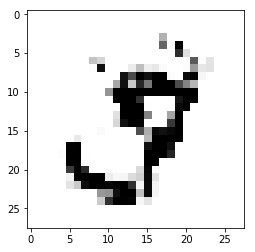

Estimate: [[-2.1094933]]
Iteration: 28200 at 2019-07-30 09:22:43.396038


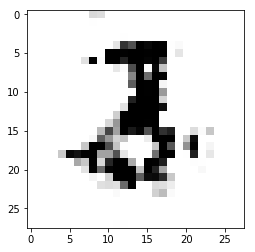

Estimate: [[-30.912561]]
Iteration: 28300 at 2019-07-30 09:24:07.272574


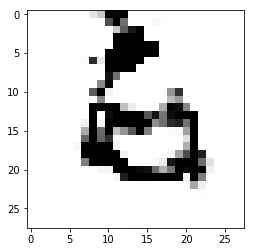

Estimate: [[13.656242]]
Iteration: 28400 at 2019-07-30 09:25:30.879981


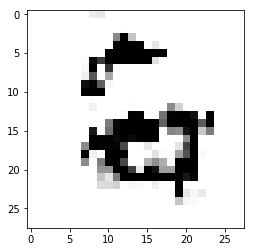

Estimate: [[45.130127]]
Iteration: 28500 at 2019-07-30 09:26:54.299408


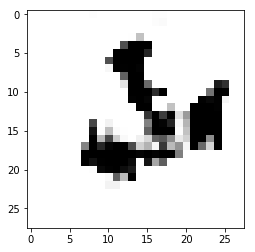

Estimate: [[-15.266645]]
Iteration: 28600 at 2019-07-30 09:28:17.773364


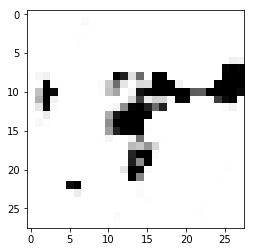

Estimate: [[151.8731]]
Iteration: 28700 at 2019-07-30 09:29:41.150587


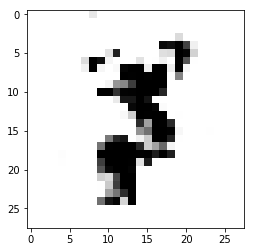

Estimate: [[-22.009485]]
Iteration: 28800 at 2019-07-30 09:31:05.228693


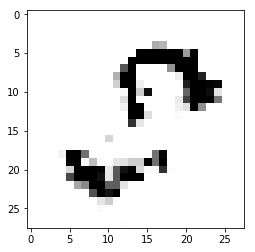

Estimate: [[-29.99061]]
Iteration: 28900 at 2019-07-30 09:32:29.260193


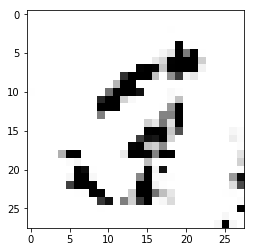

Estimate: [[-81.96667]]
Iteration: 29000 at 2019-07-30 09:33:53.049118


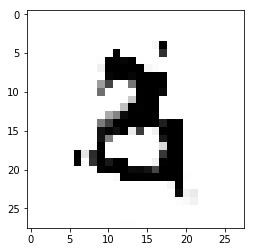

Estimate: [[20.333393]]
Iteration: 29100 at 2019-07-30 09:35:17.011708


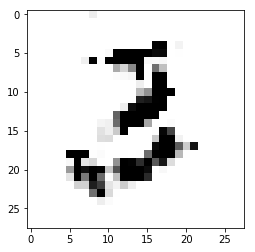

Estimate: [[20.238447]]
Iteration: 29200 at 2019-07-30 09:36:40.859918


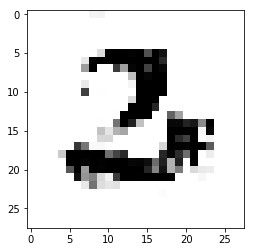

Estimate: [[28.358583]]
Iteration: 29300 at 2019-07-30 09:38:04.603516


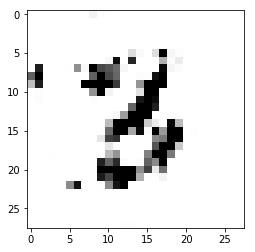

Estimate: [[-60.4887]]
Iteration: 29400 at 2019-07-30 09:39:28.311648


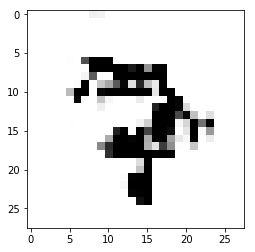

Estimate: [[-13.852182]]
Iteration: 29500 at 2019-07-30 09:40:52.418215


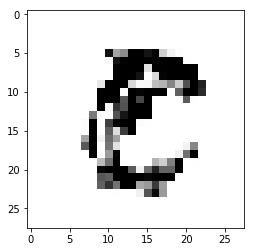

Estimate: [[2.483319]]
Iteration: 29600 at 2019-07-30 09:42:16.317203


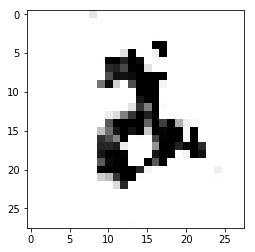

Estimate: [[18.378557]]
Iteration: 29700 at 2019-07-30 09:43:40.339548


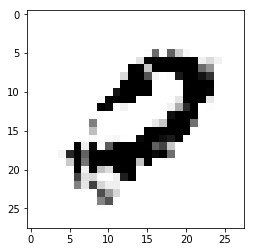

Estimate: [[51.041565]]
Iteration: 29800 at 2019-07-30 09:45:04.176479


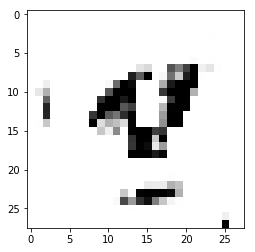

Estimate: [[10.830626]]
Iteration: 29900 at 2019-07-30 09:46:28.525814


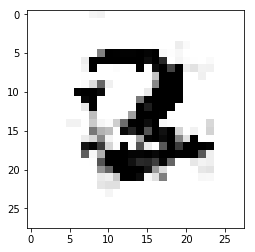

Estimate: [[-10.42039]]
Iteration: 30000 at 2019-07-30 09:47:52.697212


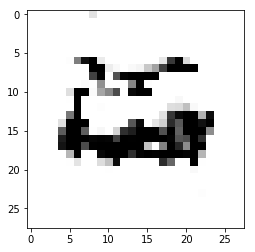

Estimate: [[19.067833]]
Iteration: 30100 at 2019-07-30 09:49:16.639857


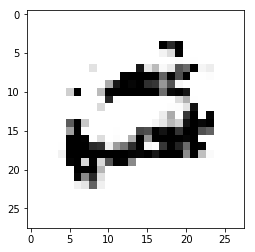

Estimate: [[17.84194]]
Iteration: 30200 at 2019-07-30 09:50:40.523180


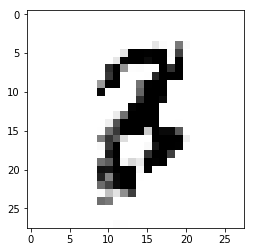

Estimate: [[49.89755]]
Iteration: 30300 at 2019-07-30 09:52:04.506191


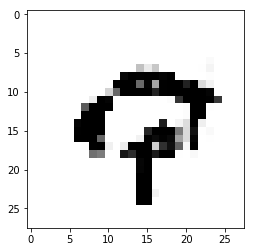

Estimate: [[0.8013451]]
Iteration: 30400 at 2019-07-30 09:53:27.860227


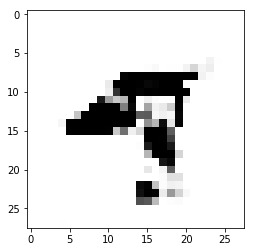

Estimate: [[19.155533]]
Iteration: 30500 at 2019-07-30 09:54:51.654465


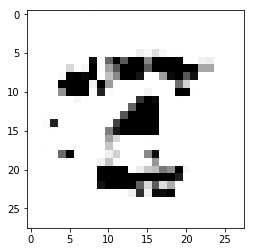

Estimate: [[-53.53393]]
Iteration: 30600 at 2019-07-30 09:56:15.463812


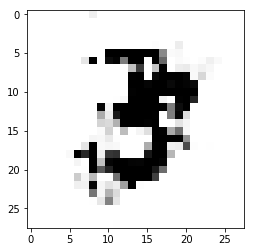

Estimate: [[-7.161595]]
Iteration: 30700 at 2019-07-30 09:57:38.895865


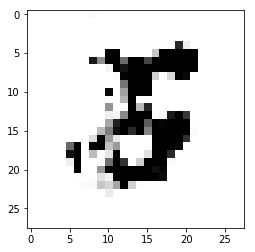

Estimate: [[-24.931185]]
Iteration: 30800 at 2019-07-30 09:59:02.416031


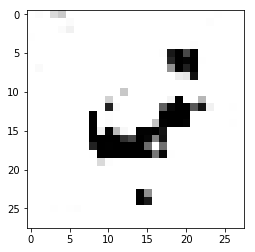

Estimate: [[-38.311123]]
Iteration: 30900 at 2019-07-30 10:00:25.941848


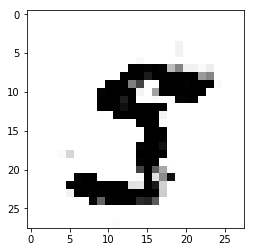

Estimate: [[-2.0008864]]
Iteration: 31000 at 2019-07-30 10:01:49.920434


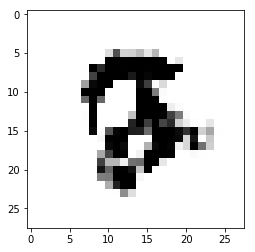

Estimate: [[34.385326]]
Iteration: 31100 at 2019-07-30 10:03:13.413260


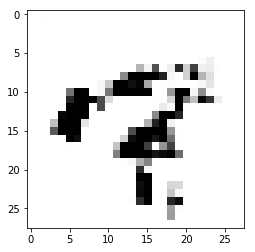

Estimate: [[25.55602]]
Iteration: 31200 at 2019-07-30 10:04:37.049213


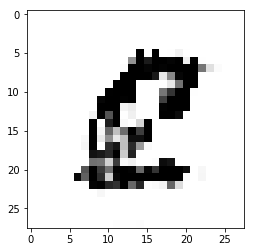

Estimate: [[8.084078]]
Iteration: 31300 at 2019-07-30 10:06:00.520151


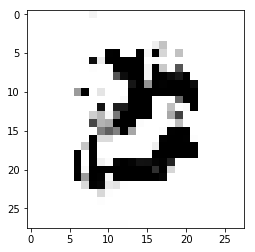

Estimate: [[1.2937255]]
Iteration: 31400 at 2019-07-30 10:07:24.131518


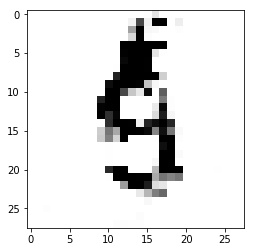

Estimate: [[-14.125635]]
Iteration: 31500 at 2019-07-30 10:08:47.797671


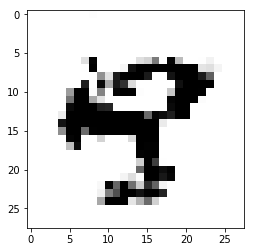

Estimate: [[109.87867]]
Iteration: 31600 at 2019-07-30 10:10:11.882800


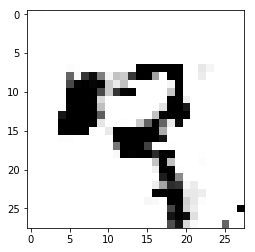

Estimate: [[5.8810863]]
Iteration: 31700 at 2019-07-30 10:11:35.559782


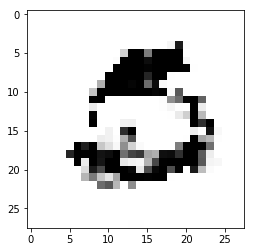

Estimate: [[-38.298042]]
Iteration: 31800 at 2019-07-30 10:12:59.571933


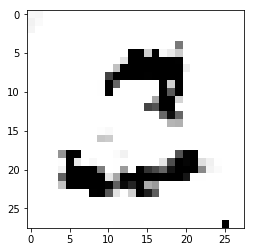

Estimate: [[7.49783]]
Iteration: 31900 at 2019-07-30 10:14:23.387081


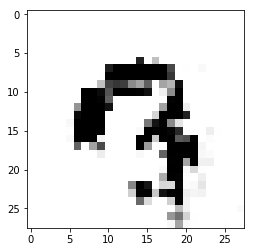

Estimate: [[2.1459281]]
Iteration: 32000 at 2019-07-30 10:15:47.481764


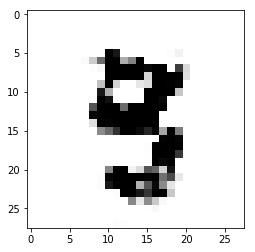

Estimate: [[14.98233]]
Iteration: 32100 at 2019-07-30 10:17:11.796053


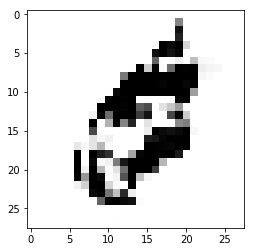

Estimate: [[27.58903]]
Iteration: 32200 at 2019-07-30 10:18:36.218686


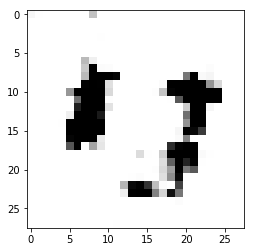

Estimate: [[-14.268104]]
Iteration: 32300 at 2019-07-30 10:20:00.477892


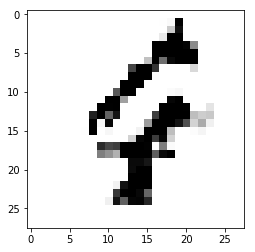

Estimate: [[47.183308]]
Iteration: 32400 at 2019-07-30 10:21:24.693320


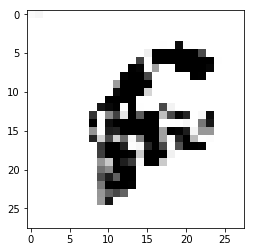

Estimate: [[36.00031]]
Iteration: 32500 at 2019-07-30 10:22:48.966647


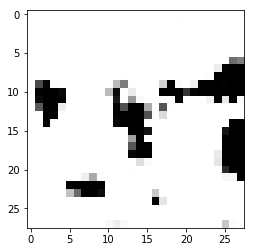

Estimate: [[515.8391]]
Iteration: 32600 at 2019-07-30 10:24:12.952102


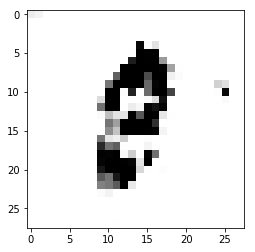

Estimate: [[-4.6964164]]
Iteration: 32700 at 2019-07-30 10:25:36.988596


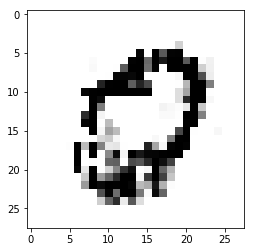

Estimate: [[-39.874588]]
Iteration: 32800 at 2019-07-30 10:27:01.142063


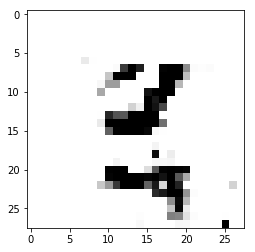

Estimate: [[35.109108]]
Iteration: 32900 at 2019-07-30 10:28:25.618112


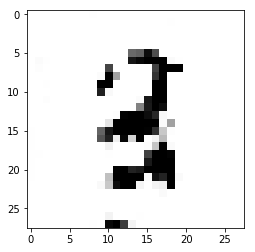

Estimate: [[-8.2598915]]
Iteration: 33000 at 2019-07-30 10:29:49.932594


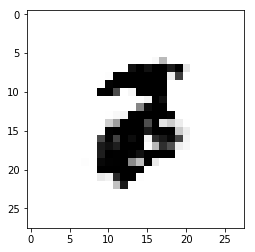

Estimate: [[16.577435]]
Iteration: 33100 at 2019-07-30 10:31:14.322688


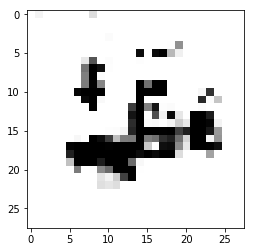

Estimate: [[15.97901]]
Iteration: 33200 at 2019-07-30 10:32:38.852652


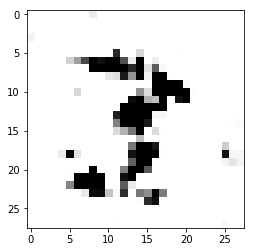

Estimate: [[-9.848973]]
Iteration: 33300 at 2019-07-30 10:34:02.947275


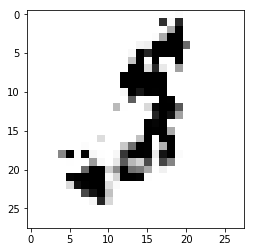

Estimate: [[58.150566]]
Iteration: 33400 at 2019-07-30 10:35:27.506610


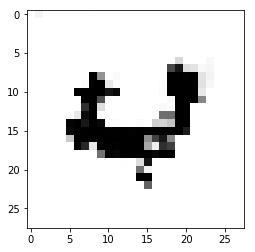

Estimate: [[6.470106]]
Iteration: 33500 at 2019-07-30 10:36:51.828031


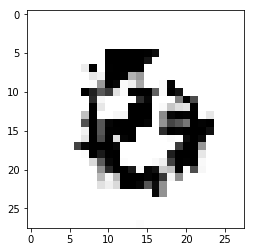

Estimate: [[3.403993]]
Iteration: 33600 at 2019-07-30 10:38:16.507742


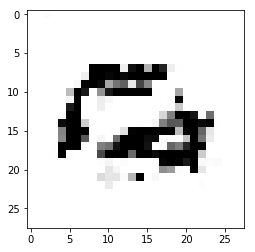

Estimate: [[15.498864]]
Iteration: 33700 at 2019-07-30 10:39:40.550386


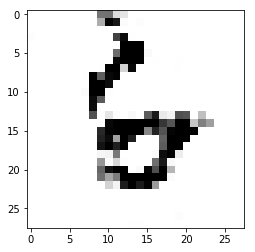

Estimate: [[45.54105]]
Iteration: 33800 at 2019-07-30 10:41:04.713254


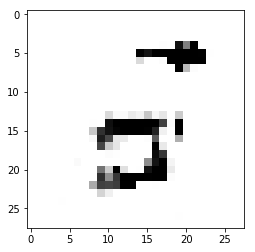

Estimate: [[2.8836133]]
Iteration: 33900 at 2019-07-30 10:42:28.830107


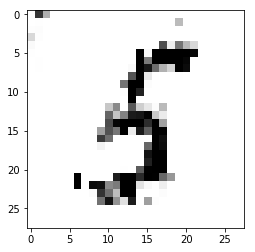

Estimate: [[-48.133205]]
Iteration: 34000 at 2019-07-30 10:43:53.362615


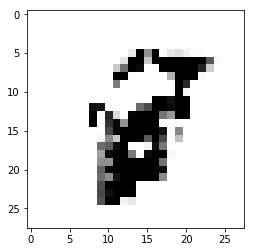

Estimate: [[54.35759]]
Iteration: 34100 at 2019-07-30 10:45:17.678978


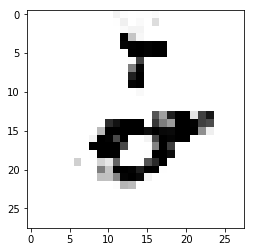

Estimate: [[-18.771343]]
Iteration: 34200 at 2019-07-30 10:46:41.951866


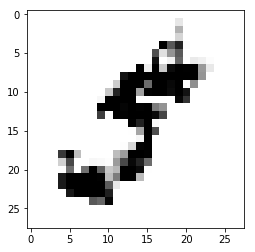

Estimate: [[25.544073]]
Iteration: 34300 at 2019-07-30 10:48:06.035134


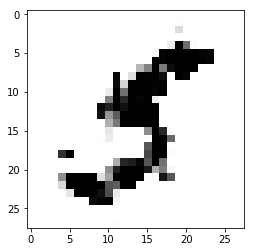

Estimate: [[51.74828]]
Iteration: 34400 at 2019-07-30 10:49:29.796212


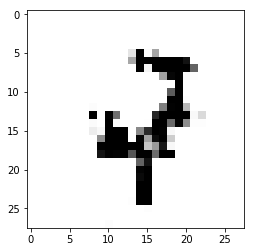

Estimate: [[21.097692]]
Iteration: 34500 at 2019-07-30 10:50:53.815117


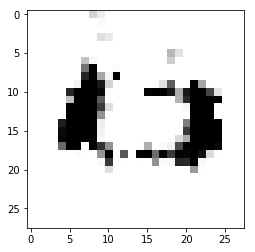

Estimate: [[72.90616]]
Iteration: 34600 at 2019-07-30 10:52:17.608481


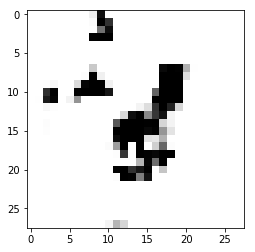

Estimate: [[-6.190101]]
Iteration: 34700 at 2019-07-30 10:53:41.660253


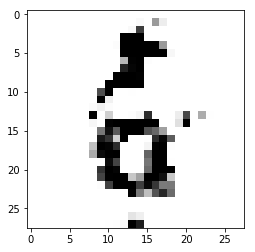

Estimate: [[61.756237]]
Iteration: 34800 at 2019-07-30 10:55:05.388657


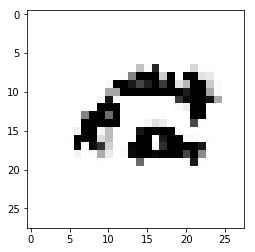

Estimate: [[-47.597427]]
Iteration: 34900 at 2019-07-30 10:56:29.705269


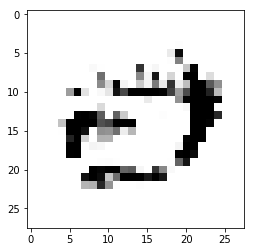

Estimate: [[97.80966]]
Iteration: 35000 at 2019-07-30 10:57:53.728415


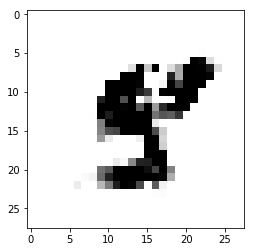

Estimate: [[-3.842944]]
Iteration: 35100 at 2019-07-30 10:59:18.219797


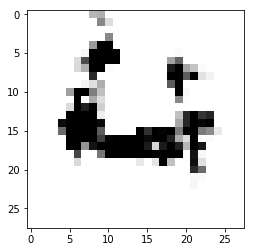

Estimate: [[44.545666]]
Iteration: 35200 at 2019-07-30 11:00:42.258712


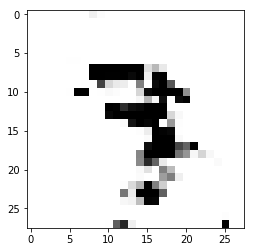

Estimate: [[52.153584]]
Iteration: 35300 at 2019-07-30 11:02:06.391186


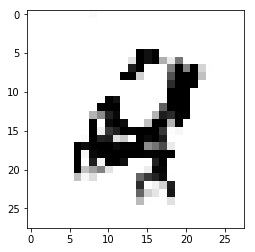

Estimate: [[12.458247]]
Iteration: 35400 at 2019-07-30 11:03:30.328223


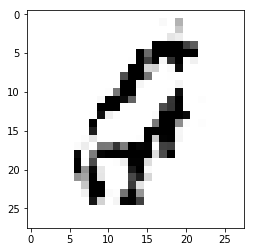

Estimate: [[-32.840725]]
Iteration: 35500 at 2019-07-30 11:04:54.723308


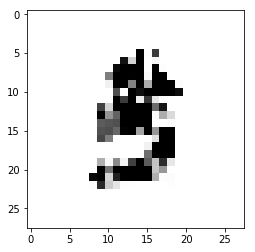

Estimate: [[-90.82346]]
Iteration: 35600 at 2019-07-30 11:06:18.604154


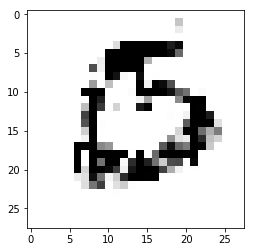

Estimate: [[1.6526664]]
Iteration: 35700 at 2019-07-30 11:07:42.883920


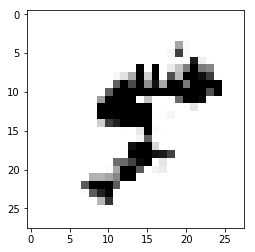

Estimate: [[1.3668951]]
Iteration: 35800 at 2019-07-30 11:09:07.067661


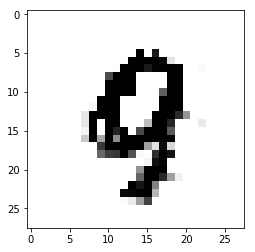

Estimate: [[-13.017912]]
Iteration: 35900 at 2019-07-30 11:10:31.241511


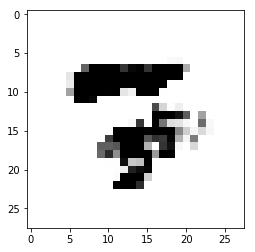

Estimate: [[1.8330206]]
Iteration: 36000 at 2019-07-30 11:11:55.003720


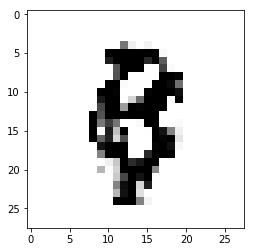

Estimate: [[-24.37982]]
Iteration: 36100 at 2019-07-30 11:13:19.091117


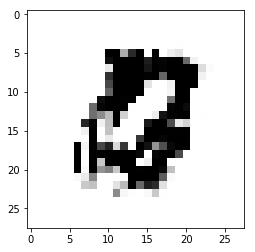

Estimate: [[68.49978]]
Iteration: 36200 at 2019-07-30 11:14:43.300765


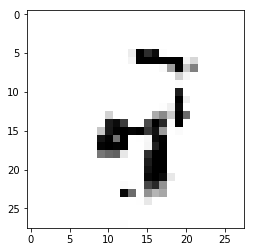

Estimate: [[22.178165]]
Iteration: 36300 at 2019-07-30 11:16:07.474928


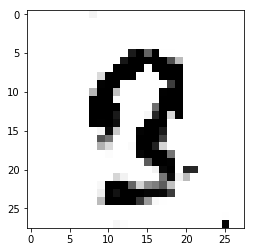

Estimate: [[11.821179]]
Iteration: 36400 at 2019-07-30 11:17:31.644447


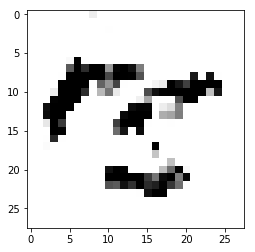

Estimate: [[81.98008]]
Iteration: 36500 at 2019-07-30 11:18:55.842942


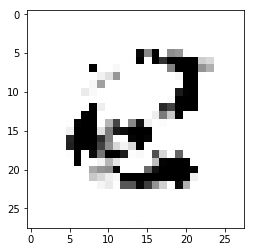

Estimate: [[-5.5637336]]
Iteration: 36600 at 2019-07-30 11:20:20.236102


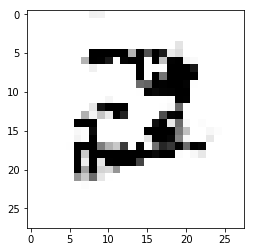

Estimate: [[-92.65338]]
Iteration: 36700 at 2019-07-30 11:21:44.333687


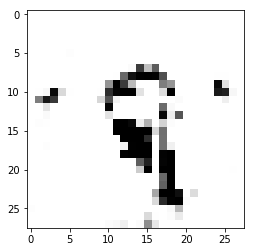

Estimate: [[51.528214]]
Iteration: 36800 at 2019-07-30 11:23:08.512997


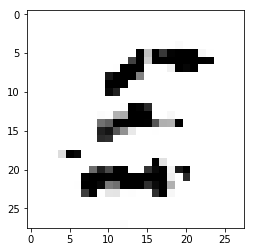

Estimate: [[18.746714]]
Iteration: 36900 at 2019-07-30 11:24:32.496719


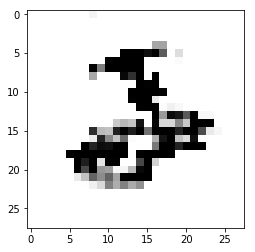

Estimate: [[-11.277473]]
Iteration: 37000 at 2019-07-30 11:25:56.630869


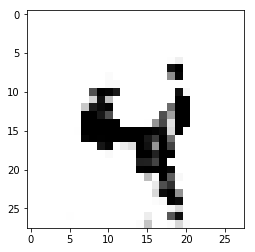

Estimate: [[5.497394]]
Iteration: 37100 at 2019-07-30 11:27:20.524710


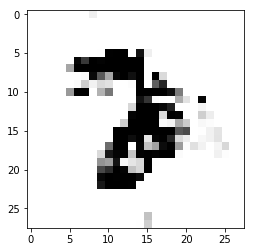

Estimate: [[4.504441]]
Iteration: 37200 at 2019-07-30 11:28:44.560607


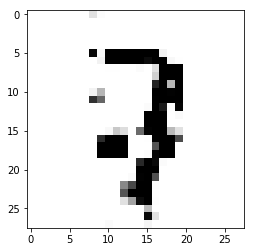

Estimate: [[-9.0156765]]
Iteration: 37300 at 2019-07-30 11:30:08.644522


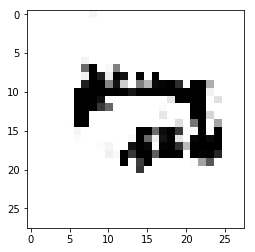

Estimate: [[-23.597033]]
Iteration: 37400 at 2019-07-30 11:31:33.037765


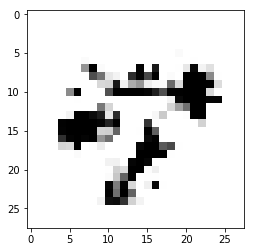

Estimate: [[-30.754395]]
Iteration: 37500 at 2019-07-30 11:32:57.191981


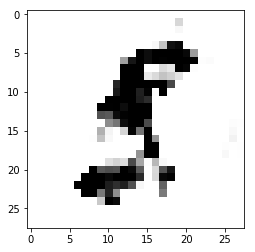

Estimate: [[-0.24422428]]
Iteration: 37600 at 2019-07-30 11:34:21.962506


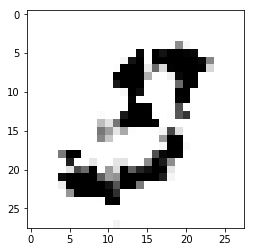

Estimate: [[59.992985]]
Iteration: 37700 at 2019-07-30 11:35:46.754594


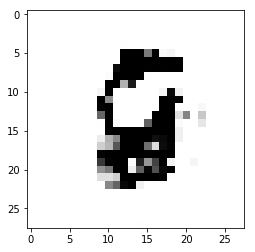

Estimate: [[-40.4736]]
Iteration: 37800 at 2019-07-30 11:37:11.551632


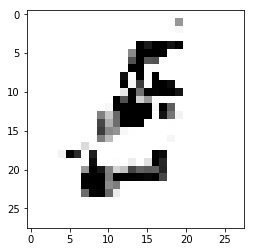

Estimate: [[-41.92679]]
Iteration: 37900 at 2019-07-30 11:38:36.056645


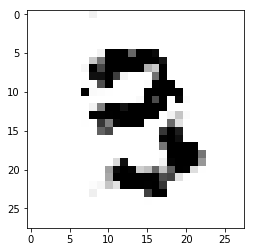

Estimate: [[-32.121532]]
Iteration: 38000 at 2019-07-30 11:40:00.858158


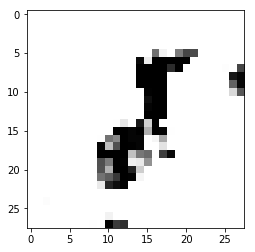

Estimate: [[11.793743]]
Iteration: 38100 at 2019-07-30 11:41:24.961727


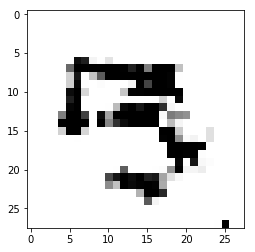

Estimate: [[4.653258]]
Iteration: 38200 at 2019-07-30 11:42:49.471774


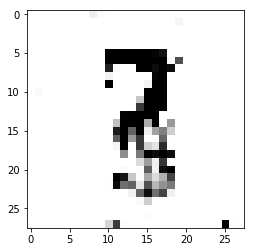

Estimate: [[24.271315]]
Iteration: 38300 at 2019-07-30 11:44:14.162395


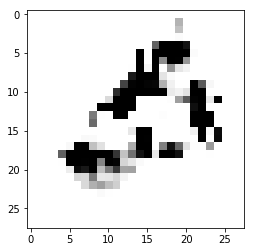

Estimate: [[22.886229]]
Iteration: 38400 at 2019-07-30 11:45:38.751520


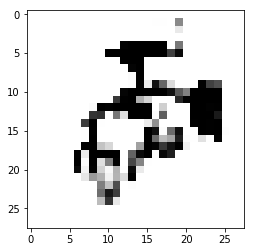

Estimate: [[-52.574833]]
Iteration: 38500 at 2019-07-30 11:47:02.788081


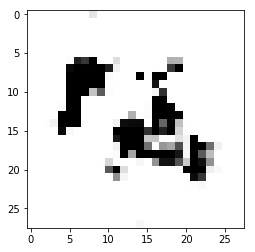

Estimate: [[42.883118]]
Iteration: 38600 at 2019-07-30 11:48:27.264215


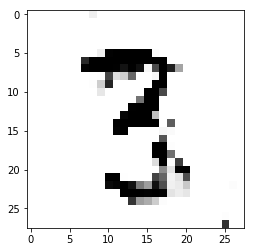

Estimate: [[20.636307]]
Iteration: 38700 at 2019-07-30 11:49:51.568441


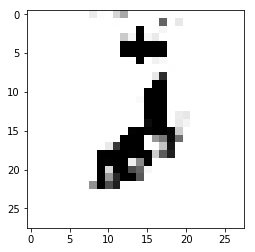

Estimate: [[21.416874]]
Iteration: 38800 at 2019-07-30 11:51:16.313852


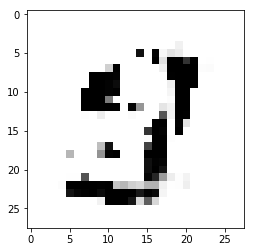

Estimate: [[63.56287]]
Iteration: 38900 at 2019-07-30 11:52:40.582607


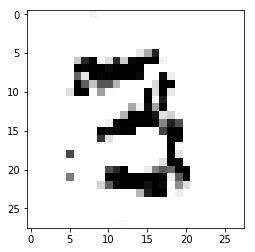

Estimate: [[-2.2046852]]
Iteration: 39000 at 2019-07-30 11:54:05.114166


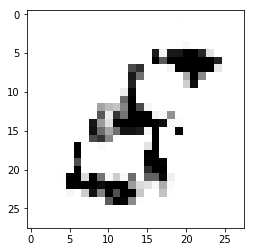

Estimate: [[7.9847236]]
Iteration: 39100 at 2019-07-30 11:55:29.679035


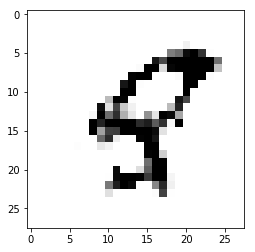

Estimate: [[15.640755]]
Iteration: 39200 at 2019-07-30 11:56:55.023632


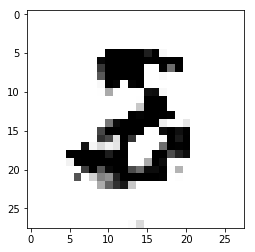

Estimate: [[10.0160055]]
Iteration: 39300 at 2019-07-30 11:58:20.779005


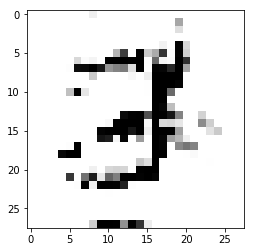

Estimate: [[-14.171722]]
Iteration: 39400 at 2019-07-30 11:59:46.375386


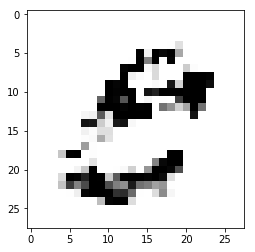

Estimate: [[0.3078435]]
Iteration: 39500 at 2019-07-30 12:01:12.282757


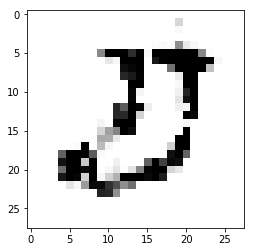

Estimate: [[-31.272013]]
Iteration: 39600 at 2019-07-30 12:02:37.921279


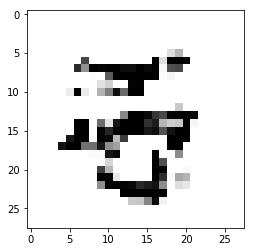

Estimate: [[-37.832607]]
Iteration: 39700 at 2019-07-30 12:04:03.355951


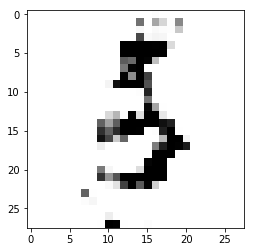

Estimate: [[-24.033564]]
Iteration: 39800 at 2019-07-30 12:05:29.047091


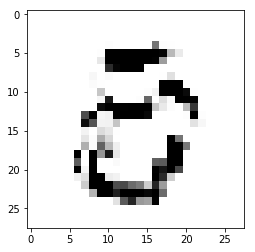

Estimate: [[-53.110653]]
Iteration: 39900 at 2019-07-30 12:06:54.850996


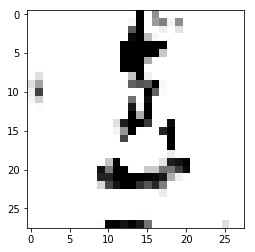

Estimate: [[-79.19629]]
Iteration: 40000 at 2019-07-30 12:08:20.756587


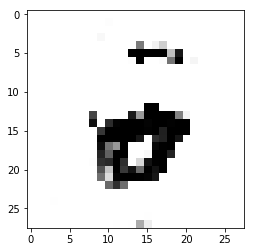

Estimate: [[63.861526]]
Iteration: 40100 at 2019-07-30 12:09:45.895820


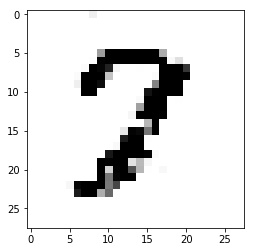

Estimate: [[15.858684]]
Iteration: 40200 at 2019-07-30 12:11:11.975062


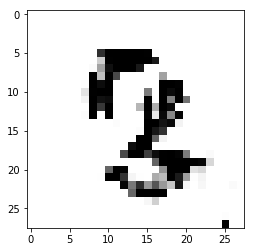

Estimate: [[1.4648438]]
Iteration: 40300 at 2019-07-30 12:12:37.070480


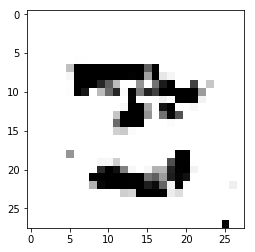

Estimate: [[-6.714736]]
Iteration: 40400 at 2019-07-30 12:14:02.742571


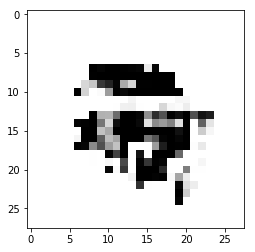

Estimate: [[26.87129]]
Iteration: 40500 at 2019-07-30 12:15:27.629704


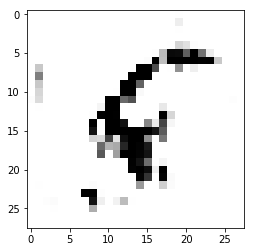

Estimate: [[-99.05387]]
Iteration: 40600 at 2019-07-30 12:16:52.978992


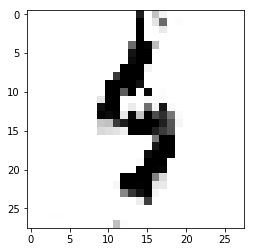

Estimate: [[-62.065334]]
Iteration: 40700 at 2019-07-30 12:18:18.233837


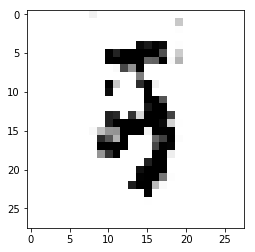

Estimate: [[-4.7339063]]
Iteration: 40800 at 2019-07-30 12:19:44.114184


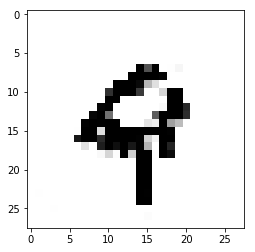

Estimate: [[45.78631]]
Iteration: 40900 at 2019-07-30 12:21:09.936314


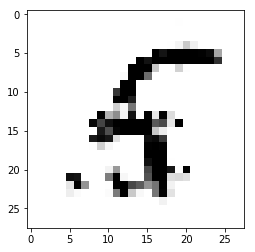

Estimate: [[-27.350822]]
Iteration: 41000 at 2019-07-30 12:22:35.684275


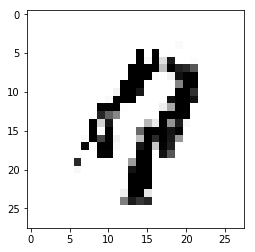

Estimate: [[39.50016]]
Iteration: 41100 at 2019-07-30 12:24:01.167812


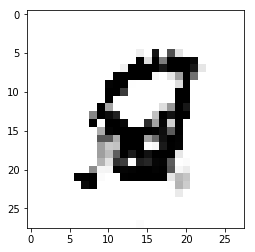

Estimate: [[27.332916]]
Iteration: 41200 at 2019-07-30 12:25:27.208858


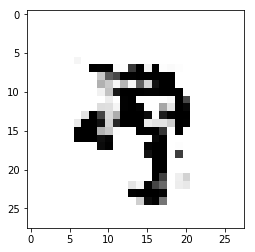

Estimate: [[37.585293]]
Iteration: 41300 at 2019-07-30 12:26:53.136268


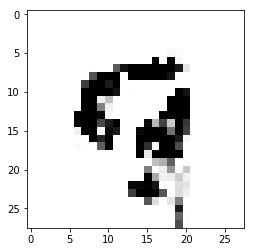

Estimate: [[12.109941]]
Iteration: 41400 at 2019-07-30 12:28:18.836118


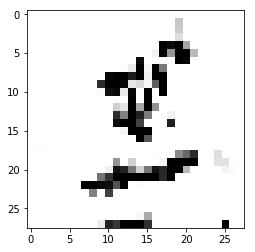

Estimate: [[-1.6363931]]
Iteration: 41500 at 2019-07-30 12:29:44.253423


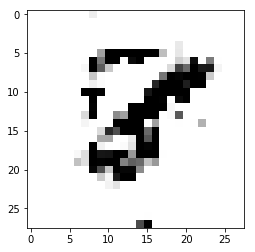

Estimate: [[56.97722]]
Iteration: 41600 at 2019-07-30 12:31:10.008629


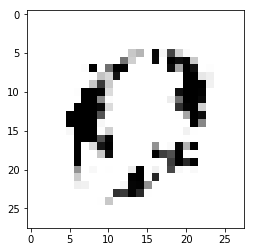

Estimate: [[-7.050188]]
Iteration: 41700 at 2019-07-30 12:32:35.417280


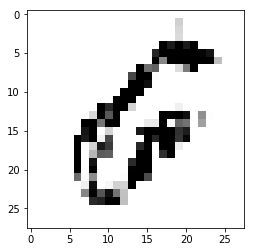

Estimate: [[58.896408]]
Iteration: 41800 at 2019-07-30 12:34:00.908930


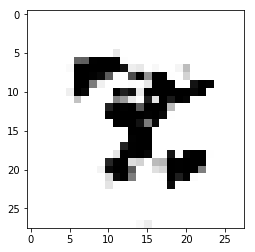

Estimate: [[58.2535]]
Iteration: 41900 at 2019-07-30 12:35:26.389222


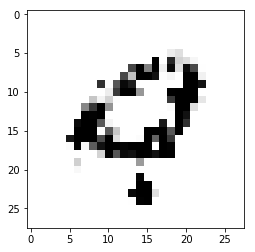

Estimate: [[-38.368362]]
Iteration: 42000 at 2019-07-30 12:36:52.082325


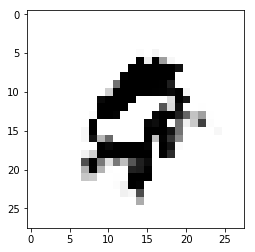

Estimate: [[34.56096]]
Iteration: 42100 at 2019-07-30 12:38:17.604300


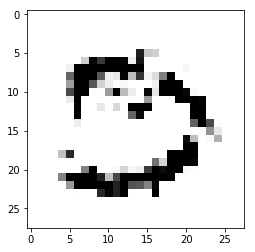

Estimate: [[41.131237]]
Iteration: 42200 at 2019-07-30 12:39:43.013794


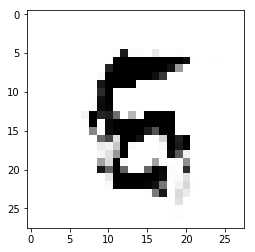

Estimate: [[8.417837]]
Iteration: 42300 at 2019-07-30 12:41:08.372798


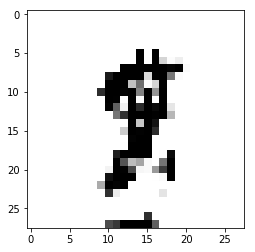

Estimate: [[51.31956]]
Iteration: 42400 at 2019-07-30 12:42:34.303635


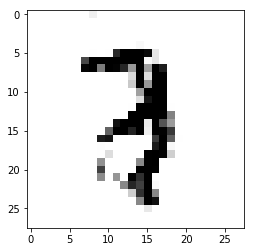

Estimate: [[-13.142156]]
Iteration: 42500 at 2019-07-30 12:43:59.744993


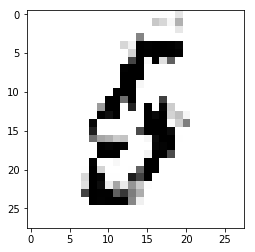

Estimate: [[47.497078]]
Iteration: 42600 at 2019-07-30 12:45:25.540712


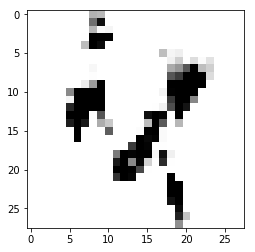

Estimate: [[8.082176]]
Iteration: 42700 at 2019-07-30 12:46:51.219660


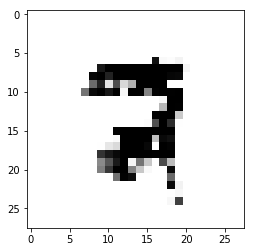

Estimate: [[-14.074134]]
Iteration: 42800 at 2019-07-30 12:48:17.219328


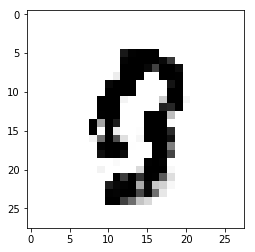

Estimate: [[9.722507]]
Iteration: 42900 at 2019-07-30 12:49:42.861606


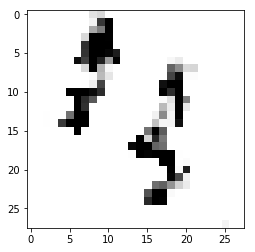

Estimate: [[12.7346735]]
Iteration: 43000 at 2019-07-30 12:51:08.969456


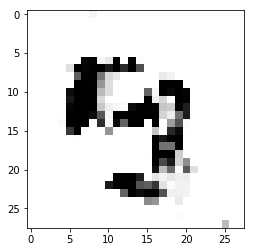

Estimate: [[27.649252]]
Iteration: 43100 at 2019-07-30 12:52:34.745201


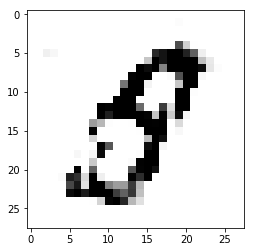

Estimate: [[14.218399]]
Iteration: 43200 at 2019-07-30 12:54:00.508484


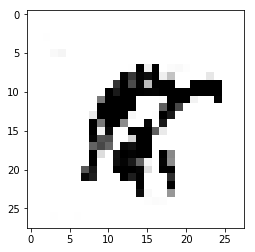

Estimate: [[-15.086392]]
Iteration: 43300 at 2019-07-30 12:55:26.104114


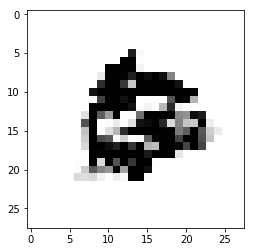

Estimate: [[-45.63346]]
Iteration: 43400 at 2019-07-30 12:56:52.283661


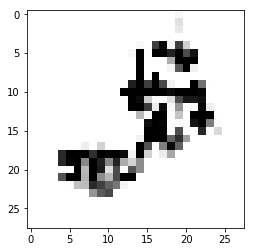

Estimate: [[22.142134]]
Iteration: 43500 at 2019-07-30 12:58:18.216607


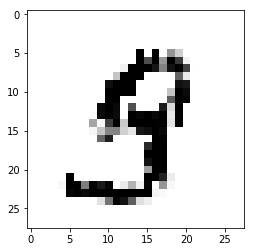

Estimate: [[-23.345055]]
Iteration: 43600 at 2019-07-30 12:59:44.364980


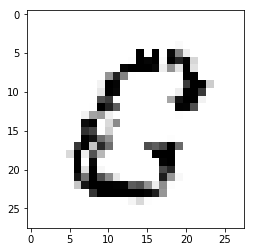

Estimate: [[-65.499115]]
Iteration: 43700 at 2019-07-30 13:01:10.417142


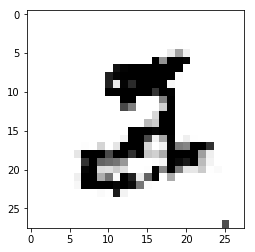

Estimate: [[-35.310097]]
Iteration: 43800 at 2019-07-30 13:02:36.241744


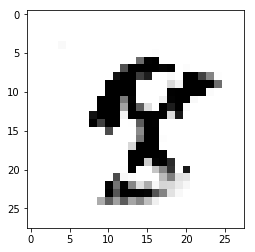

Estimate: [[10.274047]]
Iteration: 43900 at 2019-07-30 13:04:01.837613


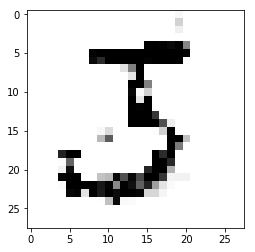

Estimate: [[-4.5663886]]
Iteration: 44000 at 2019-07-30 13:05:27.486833


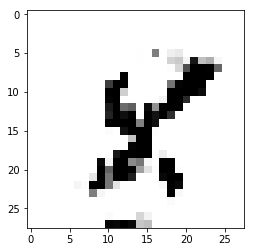

Estimate: [[-7.4168725]]
Iteration: 44100 at 2019-07-30 13:06:53.242748


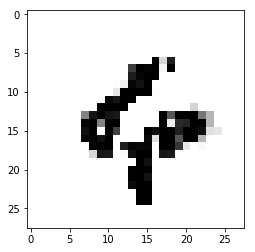

Estimate: [[8.048395]]
Iteration: 44200 at 2019-07-30 13:08:19.124802


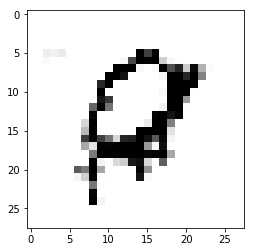

Estimate: [[0.07757502]]
Iteration: 44300 at 2019-07-30 13:09:44.536041


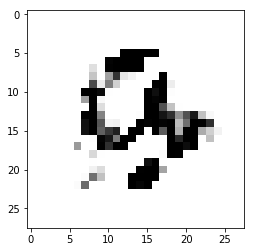

Estimate: [[20.313179]]
Iteration: 44400 at 2019-07-30 13:11:10.275999


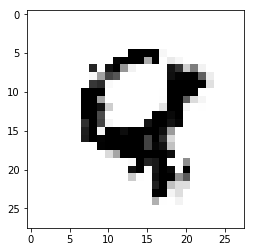

Estimate: [[16.974197]]
Iteration: 44500 at 2019-07-30 13:12:35.597983


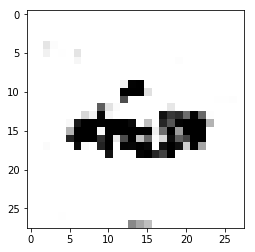

Estimate: [[-4.777678]]
Iteration: 44600 at 2019-07-30 13:14:01.575051


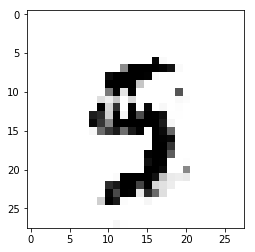

Estimate: [[-44.7742]]
Iteration: 44700 at 2019-07-30 13:15:27.291132


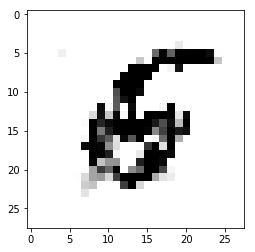

Estimate: [[-27.459295]]
Iteration: 44800 at 2019-07-30 13:16:53.114106


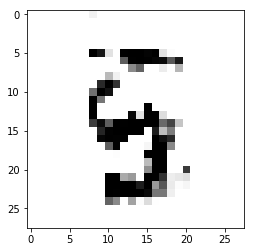

Estimate: [[16.200926]]
Iteration: 44900 at 2019-07-30 13:18:18.900184


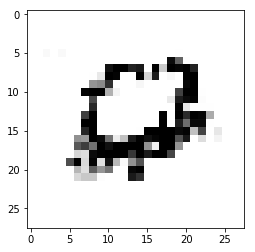

Estimate: [[14.563373]]
Iteration: 45000 at 2019-07-30 13:19:44.585686


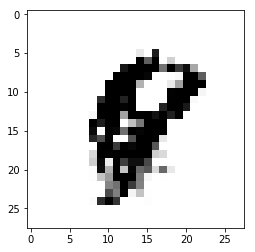

Estimate: [[-31.950466]]
Iteration: 45100 at 2019-07-30 13:21:10.662620


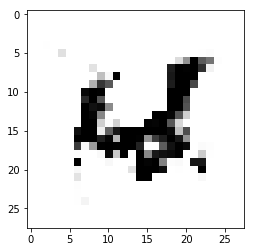

Estimate: [[38.501152]]
Iteration: 45200 at 2019-07-30 13:22:36.089116


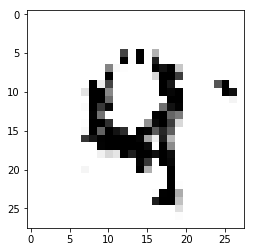

Estimate: [[19.479774]]
Iteration: 45300 at 2019-07-30 13:24:02.088141


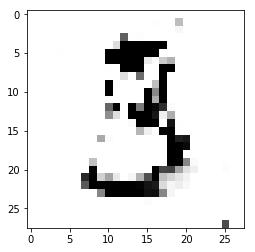

Estimate: [[8.769182]]
Iteration: 45400 at 2019-07-30 13:25:27.710779


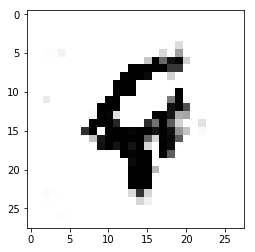

Estimate: [[47.633797]]
Iteration: 45500 at 2019-07-30 13:26:53.609745


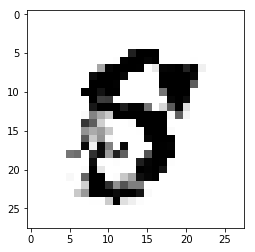

Estimate: [[10.293189]]
Iteration: 45600 at 2019-07-30 13:28:19.501222


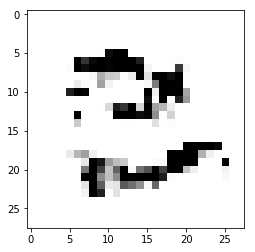

Estimate: [[-5.002185]]
Iteration: 45700 at 2019-07-30 13:29:45.517409


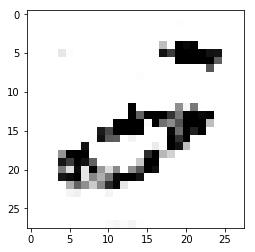

Estimate: [[25.513258]]
Iteration: 45800 at 2019-07-30 13:31:11.222228


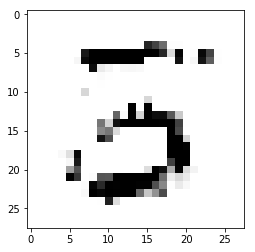

Estimate: [[30.412697]]
Iteration: 45900 at 2019-07-30 13:32:37.356022


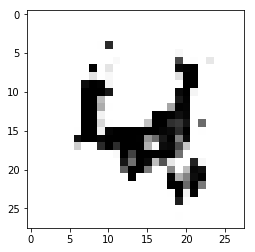

Estimate: [[-0.25712255]]
Iteration: 46000 at 2019-07-30 13:34:03.172332


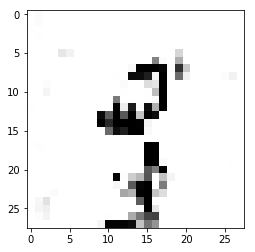

Estimate: [[-51.49164]]
Iteration: 46100 at 2019-07-30 13:35:29.288154


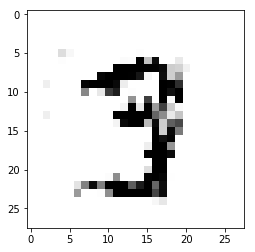

Estimate: [[-18.132774]]
Iteration: 46200 at 2019-07-30 13:36:54.882479


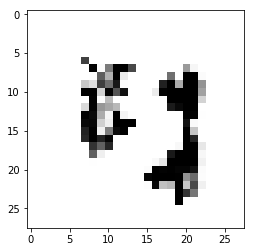

Estimate: [[78.47755]]
Iteration: 46300 at 2019-07-30 13:38:20.905343


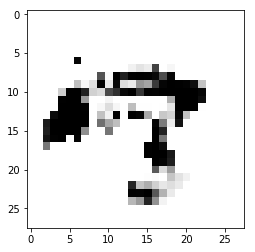

Estimate: [[1.6370826]]
Iteration: 46400 at 2019-07-30 13:39:46.834597


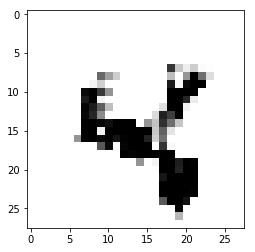

Estimate: [[38.949905]]
Iteration: 46500 at 2019-07-30 13:41:12.882405


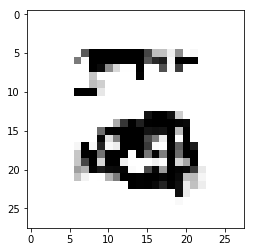

Estimate: [[28.27923]]
Iteration: 46600 at 2019-07-30 13:42:38.522897


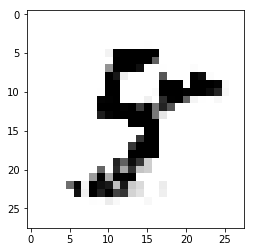

Estimate: [[38.977715]]
Iteration: 46700 at 2019-07-30 13:44:04.512601


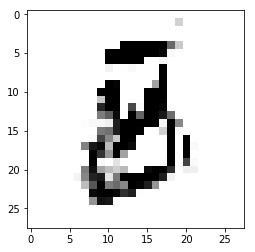

Estimate: [[-20.313793]]
Iteration: 46800 at 2019-07-30 13:45:30.453000


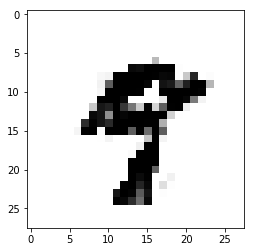

Estimate: [[29.025494]]
Iteration: 46900 at 2019-07-30 13:46:56.317302


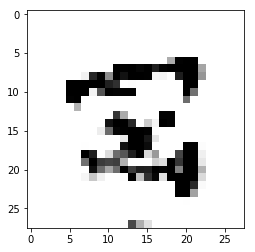

Estimate: [[-41.377693]]
Iteration: 47000 at 2019-07-30 13:48:22.124691


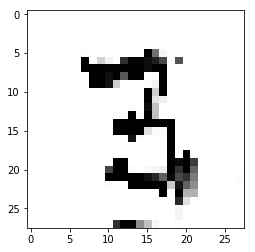

Estimate: [[-5.305792]]
Iteration: 47100 at 2019-07-30 13:49:47.984864


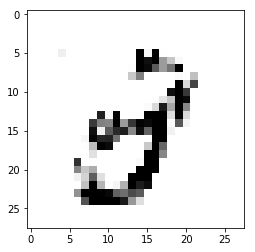

Estimate: [[3.0700767]]
Iteration: 47200 at 2019-07-30 13:51:13.856344


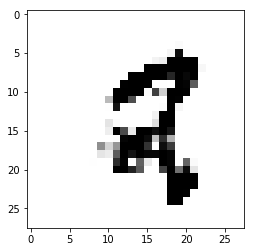

Estimate: [[66.8845]]
Iteration: 47300 at 2019-07-30 13:52:39.687964


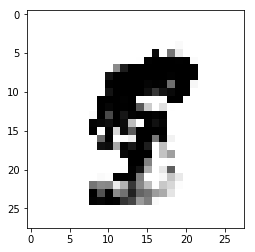

Estimate: [[55.430847]]
Iteration: 47400 at 2019-07-30 13:54:05.535387


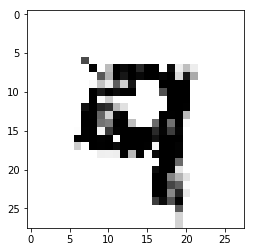

Estimate: [[27.882391]]
Iteration: 47500 at 2019-07-30 13:55:31.409231


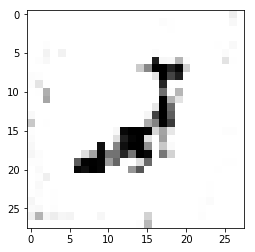

Estimate: [[-33.852882]]
Iteration: 47600 at 2019-07-30 13:56:57.113864


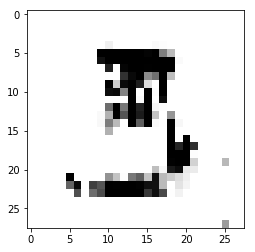

Estimate: [[36.007698]]
Iteration: 47700 at 2019-07-30 13:58:23.352228


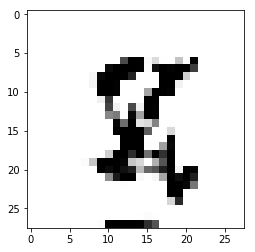

Estimate: [[16.976288]]
Iteration: 47800 at 2019-07-30 13:59:49.232728


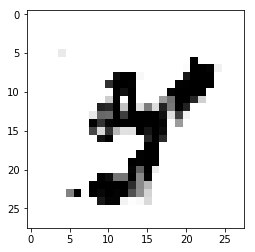

Estimate: [[7.066722]]
Iteration: 47900 at 2019-07-30 14:01:15.016179


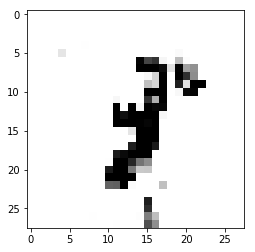

Estimate: [[12.252099]]
Iteration: 48000 at 2019-07-30 14:02:40.894472


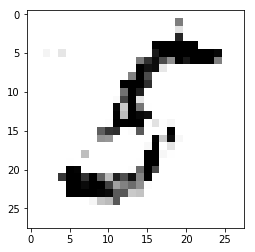

Estimate: [[29.42689]]
Iteration: 48100 at 2019-07-30 14:04:06.671715


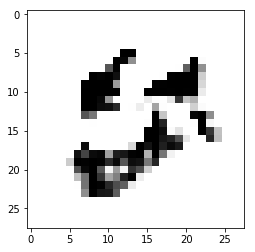

Estimate: [[5.1323485]]
Iteration: 48200 at 2019-07-30 14:05:32.983816


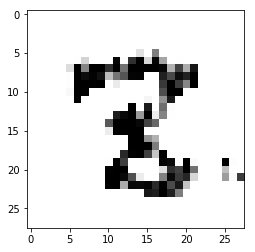

Estimate: [[6.2007236]]
Iteration: 48300 at 2019-07-30 14:06:58.794105


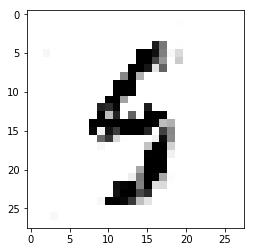

Estimate: [[26.403112]]
Iteration: 48400 at 2019-07-30 14:08:24.831189


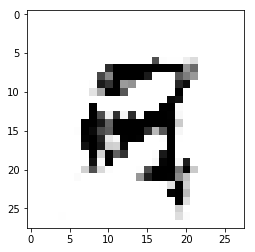

Estimate: [[-28.560137]]
Iteration: 48500 at 2019-07-30 14:09:50.547214


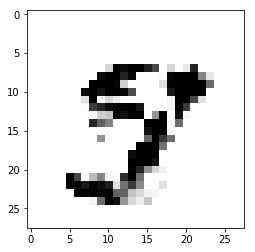

Estimate: [[-2.011333]]
Iteration: 48600 at 2019-07-30 14:11:16.811089


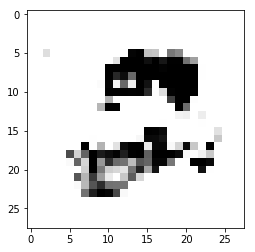

Estimate: [[-3.307014]]
Iteration: 48700 at 2019-07-30 14:12:42.081626


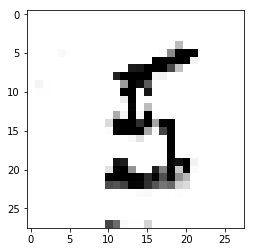

Estimate: [[4.8044324]]
Iteration: 48800 at 2019-07-30 14:14:08.414800


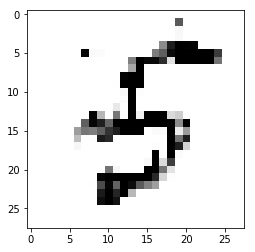

Estimate: [[57.14984]]
Iteration: 48900 at 2019-07-30 14:15:34.116897


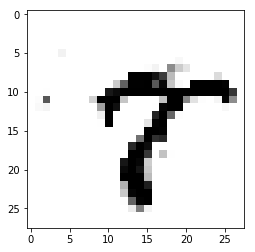

Estimate: [[-38.04158]]
Iteration: 49000 at 2019-07-30 14:17:00.362828


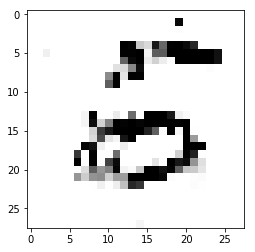

Estimate: [[56.39206]]
Iteration: 49100 at 2019-07-30 14:18:26.485983


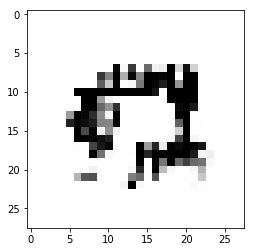

Estimate: [[-24.964706]]
Iteration: 49200 at 2019-07-30 14:19:52.604047


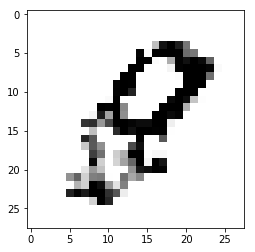

Estimate: [[-59.39498]]
Iteration: 49300 at 2019-07-30 14:21:19.352633


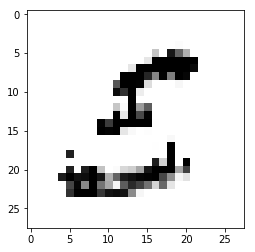

Estimate: [[-18.891987]]
Iteration: 49400 at 2019-07-30 14:22:44.994597


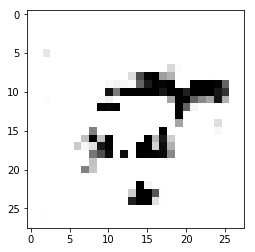

Estimate: [[38.64874]]
Iteration: 49500 at 2019-07-30 14:24:11.289068


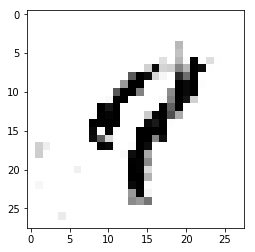

Estimate: [[-3.7623496]]
Iteration: 49600 at 2019-07-30 14:25:36.718921


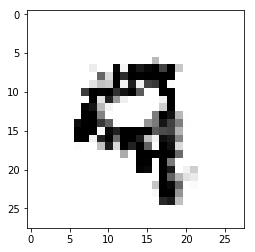

Estimate: [[3.8142354]]
Iteration: 49700 at 2019-07-30 14:27:02.935670


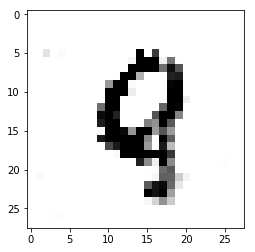

Estimate: [[44.364986]]
Iteration: 49800 at 2019-07-30 14:28:28.510780


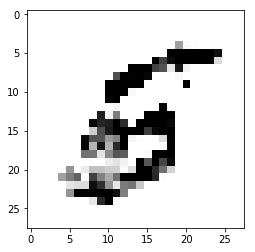

Estimate: [[42.64662]]
Iteration: 49900 at 2019-07-30 14:29:54.454911


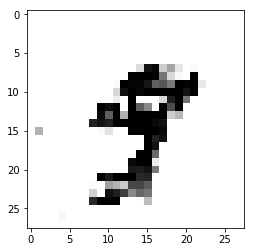

Estimate: [[4.5198717]]
Iteration: 50000 at 2019-07-30 14:31:20.389696


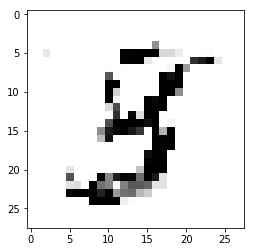

Estimate: [[27.31944]]
Iteration: 50100 at 2019-07-30 14:32:46.279601


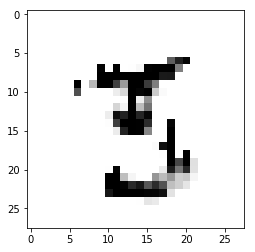

Estimate: [[-1.1162528]]
Iteration: 50200 at 2019-07-30 14:34:12.813962


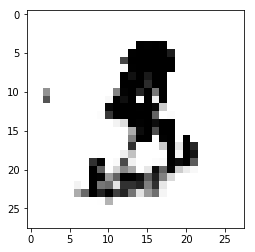

Estimate: [[-38.14361]]
Iteration: 50300 at 2019-07-30 14:35:38.913034


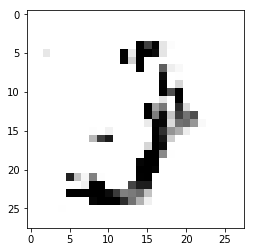

Estimate: [[-32.747032]]
Iteration: 50400 at 2019-07-30 14:37:05.653040


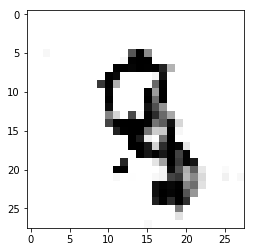

Estimate: [[1.7319468]]
Iteration: 50500 at 2019-07-30 14:38:31.724886


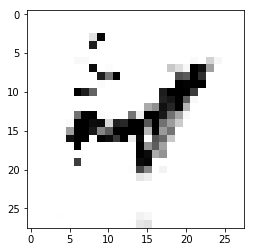

Estimate: [[3.3301513]]
Iteration: 50600 at 2019-07-30 14:39:58.219887


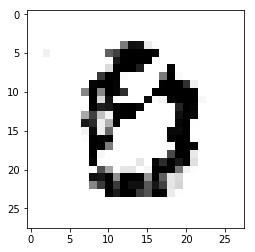

Estimate: [[-46.928177]]
Iteration: 50700 at 2019-07-30 14:41:24.300075


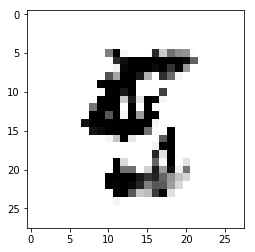

Estimate: [[30.089226]]
Iteration: 50800 at 2019-07-30 14:42:50.788902


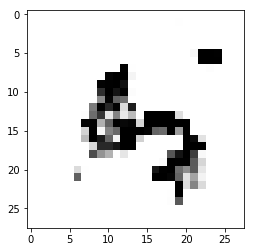

Estimate: [[51.2001]]
Iteration: 50900 at 2019-07-30 14:44:17.107751


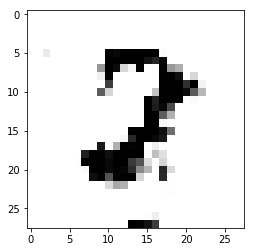

Estimate: [[-33.48423]]
Iteration: 51000 at 2019-07-30 14:45:43.288992


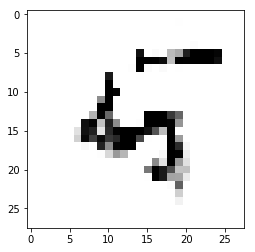

Estimate: [[26.456194]]
Iteration: 51100 at 2019-07-30 14:47:09.284510


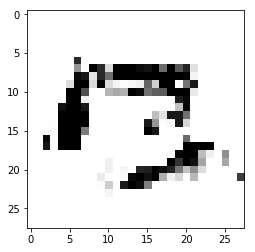

Estimate: [[-17.532637]]
Iteration: 51200 at 2019-07-30 14:48:35.291246


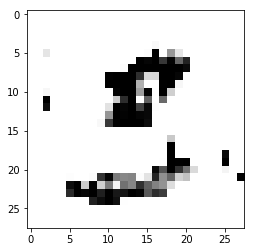

Estimate: [[83.987015]]
Iteration: 51300 at 2019-07-30 14:50:01.809025


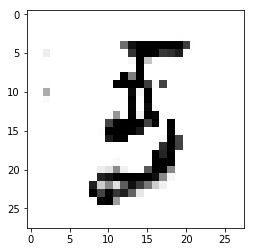

Estimate: [[57.207317]]
Iteration: 51400 at 2019-07-30 14:51:28.076328


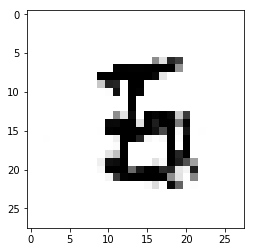

Estimate: [[68.92423]]
Iteration: 51500 at 2019-07-30 14:52:54.901957


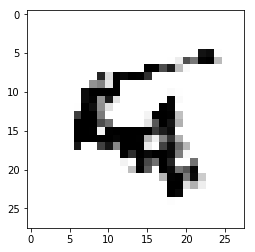

Estimate: [[49.21857]]
Iteration: 51600 at 2019-07-30 14:54:21.047472


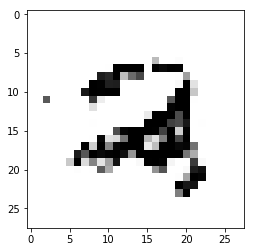

Estimate: [[67.98837]]
Iteration: 51700 at 2019-07-30 14:55:47.394558


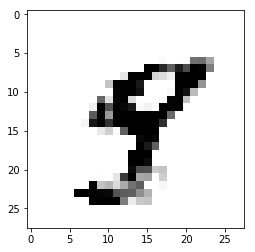

Estimate: [[83.5694]]
Iteration: 51800 at 2019-07-30 14:57:13.459593


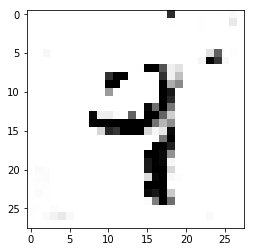

Estimate: [[-87.42051]]


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()